### Pelvis Annotator Testing and Inference

##### Author: Kellen Mulford

This is a notebook to test models trained to segment almost two dozen anatomical structures in the pelvis. The training and testing data used in this model is unique: while there were three independent annotators, the bulk of the training data comes from just one of the three. Further, each annotator independently segmented the entire 100 image test set. This allows us to perform some interrater reliability testing as well.

In [21]:
'''
Author: Kellen Mulford
Purpose: This is a notebook to perform inference and testing on pytorch
models trained to segment 22 anatomical structures of the pelvis.
'''

import os
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import numpy as np
import monai
from monai.data import ArrayDataset, decollate_batch
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AsDiscrete,
    AddChannel,
    Compose,
    LoadImage,
    ToTensor,
    ScaleIntensity,
    SqueezeDim
)
from scipy import ndimage
from scipy.ndimage import binary_dilation
from skimage.measure import (
    label,
    regionprops
)
from skimage import img_as_int
import pandas as pd
import seaborn as sns
from anatomical_structs import anatomical_labels_dict
from utils import (
    remove_background
)
import random
import imgviz

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [8]:
def get_image_paths(base_path):
    '''
    This is a function that takes a path
    and returns all the nifti files within
    the directory, It returns a sorted list
    of image files and mask files. These lists
    are sorted by the image ID which is pulled
    from the file name.
    '''
    mask_files = []
    image_files = []
    for (dirpath, _, filenames) in os.walk(base_path):
        for file in filenames:
            if file.endswith("Mask.nii"):
                mask_files.append(os.path.join(dirpath, file))
            elif file.endswith(".nii"):
                image_files.append(os.path.join(dirpath, file))
    image_test_dict = {}
    mask_test_dict = {}
    for filepath in image_files:
        img_id = re.search(r"All_(\d+)", filepath)
        try:
            image_test_dict[int(img_id.group(1))] = filepath
        except KeyError:
            print("No Patient ID Found")
            continue
    image_dict_sorted = dict(sorted(image_test_dict.items()))
    for filepath in mask_files:
        img_id = re.search(r"All_(\d+)", filepath)
        try:
            mask_test_dict[int(img_id.group(1))] = filepath
        except KeyError:
            print("No Patient ID Found")
            continue
    image_dict_sorted = dict(sorted(image_test_dict.items()))
    mask_dict_sorted = dict(sorted(mask_test_dict.items()))
    image_files_sorted = list(image_dict_sorted.values())
    mask_files_sorted = list(mask_dict_sorted.values())

    return image_files_sorted, mask_files_sorted

def inference(model, image, labels):
    '''
    Given a model, an image, and its labels
    will run the images through the model and
    deliver the formatted labels and output
    in a format that can be fed to metric functions
    '''
    transforms = Compose(
        [
            Activations(sigmoid=True),
            AsDiscrete(threshold=0.5)
        ]
    )
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        labels = labels.to(device)
        batch_size = labels.size(dim=0)
        with torch.cuda.amp.autocast():
            outputs = model(image)
        labels = remove_background(labels, 23)
        labels = dilate_points_lines(labels.cpu(), batch_size, 22).to(device)
        outputs = [transforms(i) for i in decollate_batch(outputs)]
    return labels, outputs

def test_model(model, loader):
    '''
    A specific routine for testing the
    pelvis annotation model for a specific annotator.
    '''
    dice_metric = DiceMetric(
        include_background=True,
        reduction="mean"
    )

    dice_metric_batch = DiceMetric(
        include_background=True,
        reduction="mean_batch"
    )

    for image, labels in loader:
        labels, outputs = inference(model, image, labels)
        dice_metric(y_pred=outputs, y=labels)
        dice_metric_batch(y_pred=outputs, y=labels)

    test_dice = dice_metric.aggregate().item()
    test_dice_batch = dice_metric_batch.aggregate().tolist()

    print(f"The overall Dice score on the test batch is: {round(test_dice,3)}")
    for i, struct_dice in enumerate(test_dice_batch):
        print(f"{anatomical_labels_dict[i]['name']} Dice: {round(struct_dice, 3)}")

    return test_dice, test_dice_batch

def calc_irr_dice(loader_1, loader_2, num_classes):
    '''
    This function takes two data loaders which
    load images and segmentation masks and
    returns the per class dice coefficient
    and overall dice coefficient between the two
    datasets.
    '''

    dice_metric = DiceMetric(
        include_background=True,
        reduction="mean"
    )

    dice_metric_batch = DiceMetric(
        include_background=True,
        reduction="mean_batch"
    )

    for _ in tqdm(range(100)):
        _, mask_1 = next(iter(loader_1))
        _, mask_2 = next(iter(loader_2))
        seg_onehot_1 = monai.networks.utils.one_hot(mask_1, num_classes=num_classes)
        seg_onehot_1 = seg_onehot_1[:,1:,:,:]

        seg_onehot_2 = monai.networks.utils.one_hot(mask_2, num_classes=num_classes)
        seg_onehot_2 = seg_onehot_2[:,1:,:,:]

        dice_metric(y_pred=seg_onehot_1, y=seg_onehot_2)
        dice_metric_batch(y_pred=seg_onehot_1, y=seg_onehot_2)

    dice = dice_metric.aggregate().item()
    dice_batch = dice_metric_batch.aggregate().tolist()
    return dice, dice_batch

def print_metrics(metrics):
    '''Prints metrics returned from the test_model function'''
    print(f"The overall Dice score on the test batch is: {round(metrics[0],3)}")
    for i, struct_dice in enumerate(metrics[1]):
        print(f"{anatomical_labels_dict[i]['name']} Dice: {round(struct_dice, 3)}")

def min_distance(mask_regions, label_region):
    '''
    This function takes a set of mask regions, one label region
    and calculates the minimum distance between any of centroids
    of the mask regions and the label region. The function
    returns:
        Float min_distance: The minimum distance found
        Tuple mask_centroid: The coordinates of the closest centroid
        Tuple label_centroid: The coordinates of the label centroid
    '''
    min_distance = 1e9
    mask_centroid = (0,0)
    label_centroid = label_region.centroid
    for mask_region in mask_regions:
        if mask_region.centroid and label_centroid:
            distance = np.linalg.norm(
                np.array(mask_region.centroid) - np.array(label_centroid)
            )
            if distance < min_distance:
                min_distance = distance
                mask_centroid = mask_region.centroid
    return min_distance, mask_centroid, label_centroid

def dilate_points_lines(input_mask, BATCH_SIZE, NUM_CLASSES):
    for i in range(BATCH_SIZE):
        for j in range(NUM_CLASSES):
            if anatomical_labels_dict[j]["type"] in ["point", "line"]:
                dilated_mask = binary_dilation(
                    input=input_mask[i,j,:,:].numpy(),
                    iterations=3
                )
                dilated_mask = torch.from_numpy(dilated_mask)
                
                input_mask[i,j,:,:] = dilated_mask
    return input_mask

#### Load the data

This is fairly straightforward. We will make individual data loaders for each of the three test datasets. Each is subject to the same transformations that were performed on the validation data during training.

In [9]:
BASE_PATH_1 = "REDACTED"
BASE_PATH_2 = "REDACTED"
BASE_PATH_3 = "REDACTED"

image_test_1, mask_test_1 = get_image_paths(BASE_PATH_1)
image_test_2, mask_test_2 = get_image_paths(BASE_PATH_2)
image_test_3, mask_test_3 = get_image_paths(BASE_PATH_3)


print(
    f"Annotator 1: Number of total image files: {len(image_test_1)}\t"
    f"Number of mask files: {len(mask_test_1)}"
)
print(
    f"Annotator 2: Number of total image files: {len(image_test_2)}\t"
    f"Number of mask files: {len(mask_test_2)}"
)
print(
    f"Annotator 3: Number of total image files: {len(image_test_3)}\t"
    f"Number of mask files: {len(mask_test_3)}"
)


Annotator 1: Number of total image files: 100	Number of mask files: 100
Annotator 2: Number of total image files: 100	Number of mask files: 100
Annotator 3: Number of total image files: 100	Number of mask files: 100


Now we define our transforms, which are identical to the transforms used in the validation set.

In [10]:
test_imtrans = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        ToTensor()
    ]
)

## Do not scale intensity for the segmentations
test_segtrans = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        SqueezeDim(dim=3),
        ToTensor()
    ]
)

test_data_1 = ArrayDataset(image_test_1, test_imtrans, mask_test_1, test_segtrans)
test_data_2 = ArrayDataset(image_test_2, test_imtrans, mask_test_2, test_segtrans)
test_data_3 = ArrayDataset(image_test_3, test_imtrans, mask_test_3, test_segtrans)

test_loader_1 = monai.data.DataLoader(
    test_data_1,
    batch_size=1,
    num_workers=4,
    pin_memory=True,
    shuffle=False
)
test_loader_2 = monai.data.DataLoader(
    test_data_2,
    batch_size=1,
    num_workers=4,
    pin_memory=True,
    shuffle=False
)
test_loader_3 = monai.data.DataLoader(
    test_data_3,
    batch_size=1,
    num_workers=4,
    pin_memory=True,
    shuffle=False
)


Defining the model - needs to be identical to the model from training.

In [11]:
model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=22,
    channels=(
        16, 16, 16, 
        32, 32, 32, 
        64, 64, 64, 
        128, 128, 128, 
        512, 512, 512, 
        1024, 1024, 1024,
        2048
    ),
    strides=(
        1, 1, 2,
        1, 1, 2, 
        1, 1, 2,
        1, 1, 2,
        1, 1, 2,
        1, 1, 2
    ),
    dropout=0.15,
    num_res_units=3
)

model.to(device)

scaler = torch.cuda.amp.GradScaler()
torch.backends.cudnn.benchmark = True

model.load_state_dict(torch.load(os.path.join("checkpoints", "HipModel-Dilate2-UNet20221104-112953.pth")))


<All keys matched successfully>

In [12]:
print("Model tested against Annotator 1:")
ann1_dice, ann1_struct_dice = test_model(model, test_loader_1)
print("\n\n")
print("Model tested against Annotator 2:")
ann2_dice, ann2_struct_dice = test_model(model, test_loader_2)
print("\n\n")
print("Model tested against Annotator 3:")
ann3_dice, ann3_struct_dice = test_model(model, test_loader_3)
print("\n\n")

Model tested against Annotator 1:
The overall Dice score on the test batch is: 0.748
Pelvic ring from SI joint to SI joint Dice: 0.835
Pubic symphysis Dice: 0.895
Obturator rings Dice: 0.825
Greater trochanter Dice: 0.87
Lesser trochanter Dice: 0.78
Femur on implant side Dice: 0.872
Femur on no-implant side Dice: 0.936
Subchondral bone on the acetabulum on the no-implant side Dice: 0.78
Iliac crest from ASIS posteriorly to SI joint Dice: 0.75
Teardrops Dice: 0.519
The most inferior aspects of the ischium Dice: 0.544
The medial most point on the lesser trochanter Dice: 0.583
The superior most point on the greater trochanter Dice: 0.525
The center of sacrococcygeal junction Dice: 0.303
Vertebral endplates Dice: 0.715
Femoral component Dice: 0.952
Acetabular component Dice: 0.906
Screws Dice: 0.833
Femoral Head Dice: 0.913
The distal tip of the femoral stem Dice: 0.6
The superior lateral most corner of the femoral component Dice: 0.653
Mag Markers Dice: 0.839



Model tested against Annot

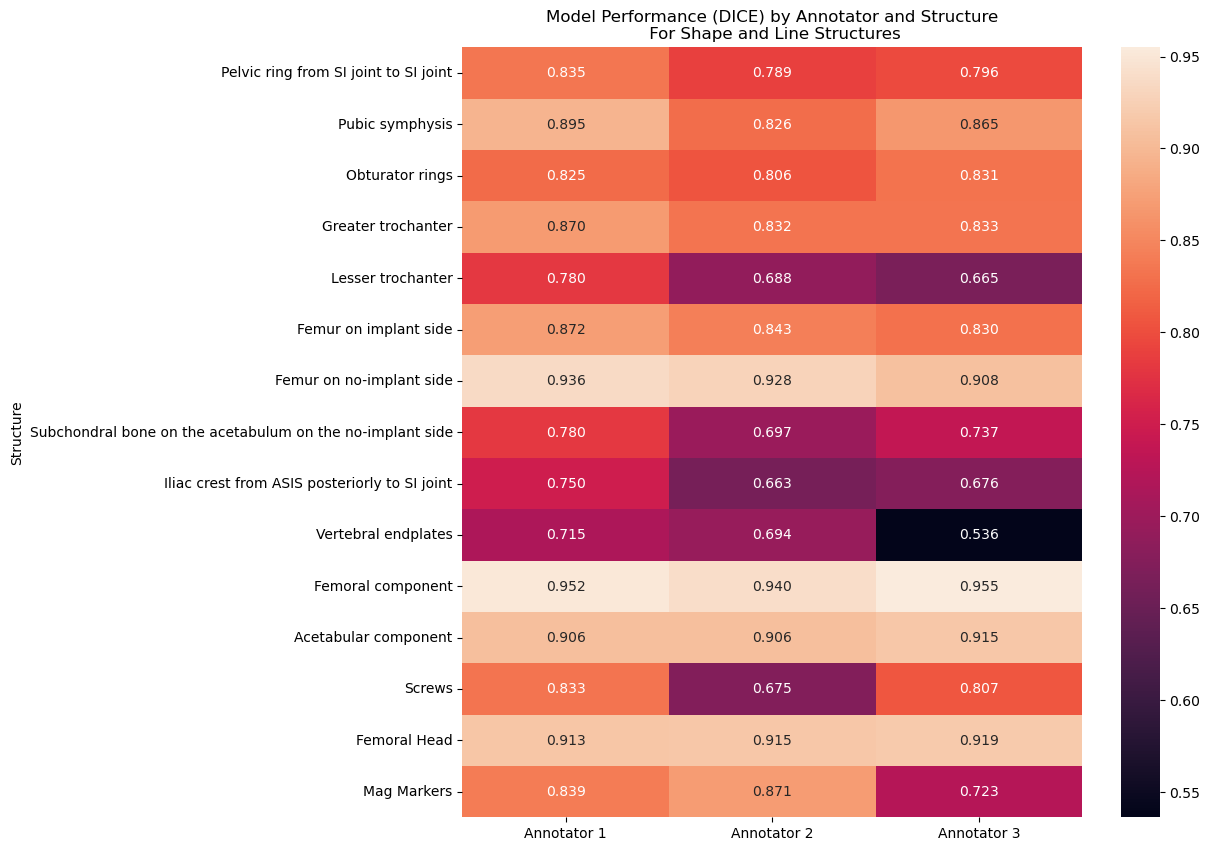

In [14]:
metric_dict_list = []
class_num = len(anatomical_labels_dict)
for i in range(class_num):
    metric_dict = {}
    metric_dict["Structure"] = anatomical_labels_dict[i]["name"]
    metric_dict["Struct-Type"] = anatomical_labels_dict[i]["type"]
    metric_dict["Annotator 1"] = ann1_struct_dice[i]
    metric_dict["Annotator 2"] = ann2_struct_dice[i]
    metric_dict["Annotator 3"] = ann3_struct_dice[i]
    metric_dict_list.append(metric_dict)

test_metric_df = pd.DataFrame(metric_dict_list).set_index("Structure")
test_metric_df = test_metric_df.loc[test_metric_df["Struct-Type"] != "point"]

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(test_metric_df.loc[:, test_metric_df.columns != "Struct-Type"], annot=True, fmt="0.3f", ax=ax)
ax.set_title("Model Performance (DICE) by Annotator and Structure\n For Shape and Line Structures")

plt.savefig("output/test_heatmap.TIF", dpi='figure', bbox_inches = "tight")
plt.savefig("output/test_heatmap.png", dpi='figure', bbox_inches = "tight")

In [18]:
def get_ave_dice(annotator_string):
    struct_sum = 0
    line_sum = 0
    point_sum = 0
    struct_count = 0
    line_count = 0
    point_count = 0
    for struct in metric_dict_list:
        if struct["Struct-Type"] == "shape":
            struct_sum += struct[annotator_string]
            struct_count += 1
        elif struct["Struct-Type"] == "line":
            line_sum += struct[annotator_string]
            line_count += 1
        elif struct["Struct-Type"] == "point":
            point_sum += struct[annotator_string]
            point_count += 1
        else:
            continue
        
    struct_ave = struct_sum / struct_count
    line_ave = line_sum / line_count
    point_ave = point_sum / point_count 

    return struct_ave, line_ave, point_ave
        
ann1_struct_ave, ann1_line_ave, ann1_point_ave = get_ave_dice("Annotator 1")
ann2_struct_ave, ann2_line_ave, ann2_point_ave = get_ave_dice("Annotator 2")
ann3_struct_ave, ann3_line_ave, ann3_point_ave = get_ave_dice("Annotator 3")

print(
    f"Annotator 1\n"
    f"Shape Average Dice: {round(ann1_struct_ave,3)}\n"
    f"Line Average Dice: {round(ann1_line_ave,3)}\n"
    f"Point Average Dice: {round(ann1_point_ave, 3)}\n\n"      
)

print(
    f"Annotator 2\n"
    f"Shape Average Dice: {round(ann2_struct_ave,3)}\n"
    f"Line Average Dice: {round(ann2_line_ave,3)}\n"
    f"Point Average Dice: {round(ann2_point_ave, 3)}\n\n"      
)

print(
    f"Annotator 3\n"
    f"Shape Average Dice: {round(ann3_struct_ave,3)}\n"
    f"Line Average Dice: {round(ann3_line_ave,3)}\n"
    f"Point Average Dice: {round(ann3_point_ave, 3)}\n\n"      
)


Annotator 1
Shape Average Dice: 0.878
Line Average Dice: 0.8
Point Average Dice: 0.532


Annotator 2
Shape Average Dice: 0.844
Line Average Dice: 0.746
Point Average Dice: 0.429


Annotator 3
Shape Average Dice: 0.84
Line Average Dice: 0.74
Point Average Dice: 0.576




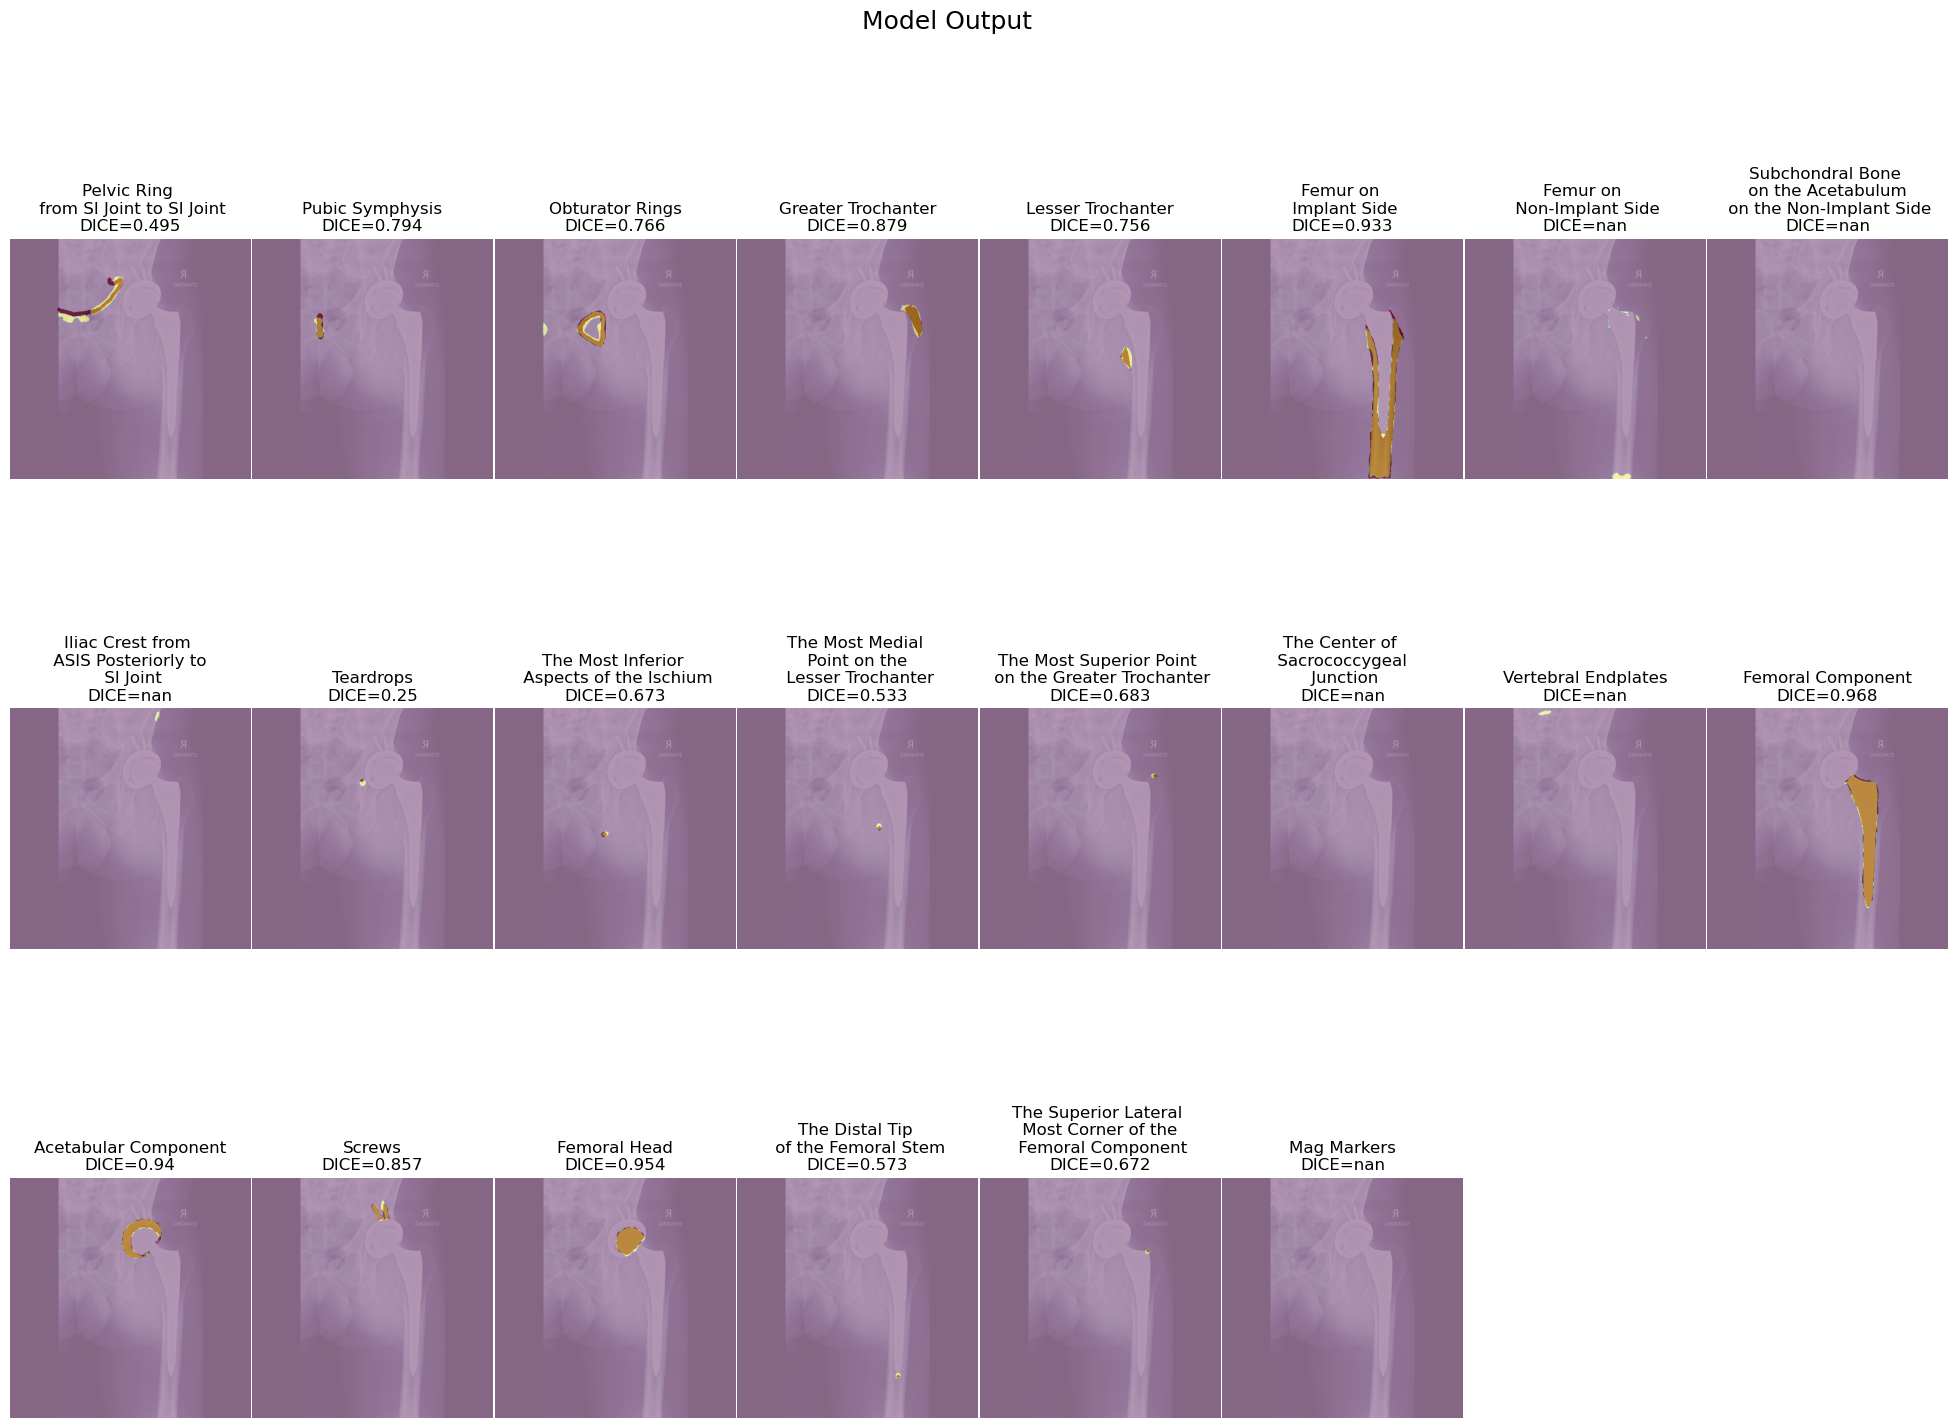

In [20]:
import random
for i in range(random.randint(0, 100)):
    example_image, example_labels = next(iter(test_loader_1))

example_dice_metric = DiceMetric(
    include_background=True,
    reduction="mean"
)

example_dice_metric_batch = DiceMetric(
    include_background=True,
    reduction="none"
)

example_labels, example_outputs = inference(model, example_image, example_labels)

example_dice_metric(y_pred=example_outputs, y=example_labels)
example_dice_metric_batch(y_pred=example_outputs, y=example_labels)

example_dice = example_dice_metric.aggregate().item()
example_dice_batch = example_dice_metric_batch.aggregate().tolist()

plt.figure( figsize=(25,18))
plt.subplots_adjust(
    hspace=0.05,
    wspace=.01,
)
plt.suptitle("Model Output", fontsize=18, y=0.95)
num_classes=22
nrows = 3

for n in range(num_classes):
    ax = plt.subplot(nrows, 8, n + 1)
    mask = example_outputs[0].cpu()[n]
    gt_mask = example_labels[0].cpu()[n]
    ax.imshow(ndimage.rotate(example_image[0].cpu()[0],90), alpha=1.0, cmap=plt.cm.bone)
    ax.imshow(ndimage.rotate(gt_mask, 90), alpha=0.7, cmap=plt.cm.Reds)
    ax.imshow(ndimage.rotate(mask, 90), alpha=0.4)
    ax.axis('off')
    ax.set_title(
        f"{anatomical_labels_dict[n]['name_formatted']}"
        f"\nDICE={round(example_dice_batch[0][n],3)}"
    )

example_dice_metric.reset()
example_dice_metric_batch.reset()


Grab a random image from the test set and display model output side by side with labels

(1, 22, 512, 512)
(512, 512)


Text(0.5, 1.0, 'Ground Truth')

<Figure size 2000x2000 with 0 Axes>

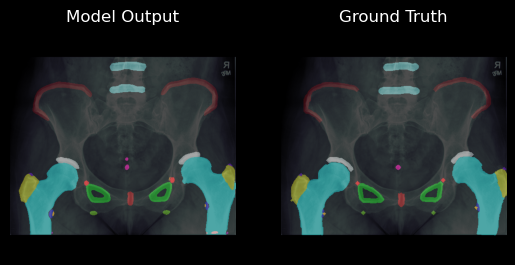

In [32]:
rand_int = random.randint(0,100)
ind = 0
for img, lab in test_loader_1:
    example_image, example_labels = img, lab
    if ind == rand_int:
        break
    ind += 1
    
example_labels, example_outputs = inference(model, example_image, example_labels)
example_outputs = torch.stack(example_outputs).cpu()
print(example_outputs.shape)
example_outputs = np.argmax(np.squeeze(example_outputs, 0), axis=0)
example_labels = np.argmax(np.squeeze(example_labels.cpu(), 0), axis=0)
print(example_outputs.shape)

example_image.shape
viz = imgviz.label2rgb(example_outputs, alpha=0.25)
label_vis = imgviz.label2rgb(example_labels, alpha=0.25)

plt.style.use('dark_background')
plt.figure(figsize=(20,20))
fig, axarr = plt.subplots(1,2)

axarr[0].imshow(ndimage.rotate(example_image[0].cpu()[0],90), alpha=1, cmap=plt.cm.bone)
axarr[0].imshow(ndimage.rotate(viz,90), alpha=0.7)
axarr[0].axis('off')
axarr[0].set_title(
    "Model Output"
)

axarr[1].imshow(ndimage.rotate(example_image[0].cpu()[0],90), alpha=1, cmap=plt.cm.bone)
axarr[1].imshow(ndimage.rotate(label_vis,90), alpha=0.7)
axarr[1].axis('off')
axarr[1].set_title(
    "Ground Truth"
)
#plt.savefig("output/pelvis-model-comparison-error-mode1.TIF", dpi="figure")

### IRR assessment

In [26]:
ann1_ann2_metrics = calc_irr_dice(test_loader_1, test_loader_2, 23)
ann1_ann3_metrics = calc_irr_dice(test_loader_1, test_loader_3, 23)
ann2_ann3_metrics = calc_irr_dice(test_loader_2, test_loader_3, 23)

print_metrics(ann1_ann2_metrics)
print("\n\n")
print_metrics(ann1_ann3_metrics)
print("\n\n")
print_metrics(ann2_ann3_metrics)


100%|██████████| 100/100 [01:43<00:00,  1.03s/it]

The overall Dice score on the test batch is: 0.479
Pelvic ring from SI joint to SI joint Dice: 0.663
Pubic symphysis Dice: 0.753
Obturator rings Dice: 0.581
Greater trochanter Dice: 0.779
Lesser trochanter Dice: 0.771
Femur on implant side Dice: 0.894
Femur on no-implant side Dice: 0.0
Subchondral bone on the acetabulum on the no-implant side Dice: 0.0
Iliac crest from ASIS posteriorly to SI joint Dice: 0.0
Teardrops Dice: 0.0
The most inferior aspects of the ischium Dice: 0.0
The medial most point on the lesser trochanter Dice: 0.0
The superior most point on the greater trochanter Dice: 0.077
The center of sacrococcygeal junction Dice: 0.0
Vertebral endplates Dice: 0.0
Femoral component Dice: 0.952
Acetabular component Dice: 0.938
Screws Dice: 0.705
Femoral Head Dice: 0.957
The distal tip of the femoral stem Dice: 0.333
The superior lateral most corner of the femoral component Dice: 0.222
Mag Markers Dice: 0.0



The overall Dice score on the test batch is: 0.55
Pelvic ring from SI jo

### Assessing error distance for point structures

In [28]:
point_test_metrics = []
IMG_NUM = 0
for test_image, test_labels in test_loader_1:
    IMG_NUM += 1
    test_labels, test_outputs = inference(model, test_image, test_labels)
    for anat_label in anatomical_labels_dict:
        if anat_label["type"] == "point":
            CHANNEL = anat_label["channel"]
            
            # Covert to label image
            label_image = label(img_as_int(test_labels[:,CHANNEL,:,:].cpu().numpy()))
            label_output = label(img_as_int(test_outputs[0][CHANNEL,:,:].cpu().numpy()))
            
            # Extract region properties to calculate centroid
            image_regionprops = regionprops(np.squeeze(label_image))
            output_regionprops = regionprops(np.squeeze(label_output))

            for i, region in enumerate(image_regionprops):
                                
                # For use in dataframe
                test_metrics = {}
                test_metrics["img_num"] = IMG_NUM
                test_metrics["struct"] = anat_label["name"]
                test_metrics["struct_fmt"] = anat_label["name_formatted"]
                test_metrics["region_count"] = i

                # Calculate minimum centroid distance (to get around bilaterality of images)
                x, y, z = min_distance(output_regionprops, region)
                test_metrics["min_distance"] = x
                test_metrics["mask_centroid"] = y
                test_metrics["label_centroid"] = z

                point_test_metrics.append(test_metrics)


/tmp/ipykernel_20624/1195054400.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_below_thresh["min_distance"] = df2_below_thresh["min_distance"].apply(lambda x: x * 0.82) #Updated pixel spacing


[Text(0.5, 0, 'Log(Distance in mm)'), Text(0, 0.5, 'Structure')]

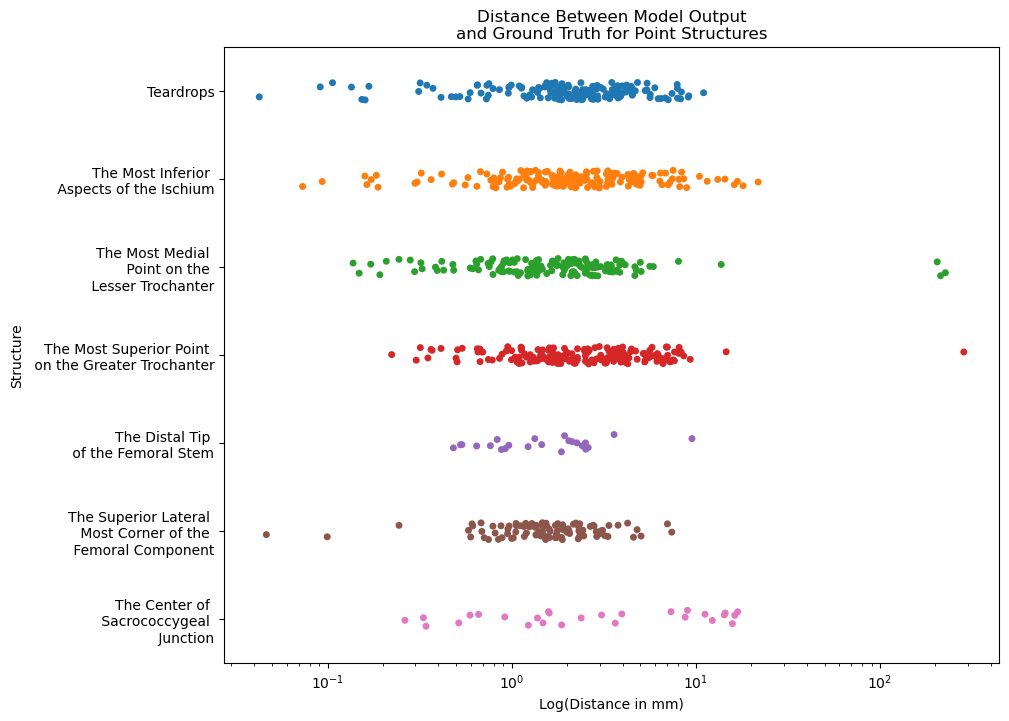

In [31]:
# Stripplot of centroid distances

plt.style.use('default')
df2 = pd.DataFrame.from_dict(point_test_metrics)
df2["min_distance_log"] = np.log10(df2["min_distance"])
df2_below_thresh = df2[(df2["min_distance"] < 1000)]
df2_below_thresh["min_distance"] = df2_below_thresh["min_distance"].apply(lambda x: x * 0.82) #Updated pixel spacing

fig, ax = plt.subplots(figsize=(10,8))
sns.stripplot(data=df2_below_thresh, y="struct_fmt", x="min_distance", hue="struct_fmt", legend=None)
ax.set_xscale("log")
ax.set_title("Distance Between Model Output\nand Ground Truth for Point Structures")
ax.set(xlabel='Log(Distance in mm)', ylabel='Structure')

#plt.savefig("output/stripplot_points_final.TIF", dpi='figure', bbox_inches = "tight")
#plt.savefig("output/stripplot_points_final.png", dpi='figure', bbox_inches = "tight")

Excluding laterality errors, calculate the mean centroid distance from ground truth

In [78]:
df2_below_thresh2 = df2_below_thresh[(df2_below_thresh["min_distance"] < 100)]
df2_below_thresh2.groupby(['struct']).mean()

img_num  region_count  \
struct                                                                        
Teardrops                                           52.195122      0.414634   
The center of sacrococcygeal junction               44.666667      0.000000   
The distal tip of the femoral stem                  42.304348      0.086957   
The medial most point on the lesser trochanter      49.972028      0.384615   
The most inferior aspects of the ischium            52.409091      0.431818   
The superior lateral most corner of the femoral...  61.336634      0.346535   
The superior most point on the greater trochanter   52.445783      0.397590   

                                                    min_distance  \
struct                                                             
Teardrops                                               2.724602   
The center of sacrococcygeal junction                   5.631997   
The distal tip of the femoral stem                      1.911359   
The medial most point on the lesser trochanter          2.201252   
The most inferior aspects of the ischium                3.097997   
The superior lateral most corner of the femoral...      1.853375   
The superior most point on the greater trochanter       3.013345   

                                                    min_distance_log  
struct                                                                
Teardrops                                                   0.377294  
The center of sacrococcygeal junction                       0.518199  
The distal tip of the femoral stem                          0.247047  
The medial most point on the lesser trochanter              0.282927  
The most inferior aspects of the ischium                    0.385408  
The superior lateral most corner of the femoral...          0.265936  
The superior most point on the greater trochanter           0.435575

### Set up the qualitative evaluation

In [13]:
from random import randint

def random_with_N_digits(n):
    range_start = 10**(n-1)
    range_end = (10**n)-1
    return randint(range_start, range_end)

val_dicts = []

IMG_NUM = 0
fig_list = []
for test_image, test_labels in test_loader_1:
    IMG_NUM += 1
    with torch.no_grad():
        test_labels, test_outputs = inference(model, test_image, test_labels)
        for n, anat_label in enumerate(anatomical_labels_dict):       
            if anat_label["type"] == "point":
                
                ## Model output
                val_dict = {}
                val_dict["img_num"] = IMG_NUM
                val_dict["struct"] = anat_label["name"]                   
                val_dict["rand_code"] = random_with_N_digits(8)
                val_dict["GT"] = 0
                    
                ## Figure Time
                plt.figure( figsize=(10,10))
                plt.subplots_adjust(
                    hspace=0.23,
                    wspace=.05,
                )
                plt.suptitle(f"{anat_label['name']}\nCode: {val_dict['rand_code']}", fontsize=18, y=0.95)
                i=0
                ax = plt.subplot(1, 1, 1)
                mask = test_outputs[0].cpu()[n]
                ax.imshow(
                    ndimage.rotate(test_image[0].cpu()[0],90),
                    alpha=1.0,
                    cmap=plt.cm.bone
                )
                ax.imshow(ndimage.rotate(mask, 90), alpha=0.5)
                ax.axis('off')
                
                plt.savefig(os.path.join("val_images", f"{val_dict['rand_code']}.png"))
                val_dicts.append(val_dict)
                plt.close()
                ## GT label
                
                ## Ground truth output
                val_dict = {}
                val_dict["img_num"] = IMG_NUM
                val_dict["struct"] = anat_label["name"]                   
                val_dict["rand_code"] = random_with_N_digits(8)
                val_dict["GT"] = 1
                    
                ## Figure Time
                plt.figure( figsize=(10,10))
                plt.subplots_adjust(
                    hspace=0.23,
                    wspace=.05,
                )
                plt.suptitle(f"{anat_label['name']}\nCode: {val_dict['rand_code']}", fontsize=18, y=0.95)
                i=0
                ax = plt.subplot(1, 1, 1)
                gt_mask = test_labels[0].cpu()[n]
                ax.imshow(
                    ndimage.rotate(test_image[0].cpu()[0],90),
                    alpha=1.0,
                    cmap=plt.cm.bone
                )
                ax.imshow(ndimage.rotate(gt_mask, 90), alpha=0.5)
                ax.axis('off')
                
                plt.savefig(os.path.join("val_images", f"{val_dict['rand_code']}.png"))
                val_dicts.append(val_dict)                    
                plt.close()  

pd.DataFrame(val_dicts).to_csv(os.path.join("val_images", "val_key.csv"))


In [12]:
val_df = pd.read_csv("hip-eval-results.csv")
val_df = val_df.rename(columns={"l_num_flat": "left", "r_num_flat": "right"}).melt(id_vars=['img_num', 'struct'])
val_df.groupby(['struct', 'value']).count()

### Examine images with centroid distances larger than 15 mm

In [ ]:
df_above_thresh = df2[(df2["min_distance"] > 15) & (df2["min_distance"] < 10000)]
display(df_above_thresh)

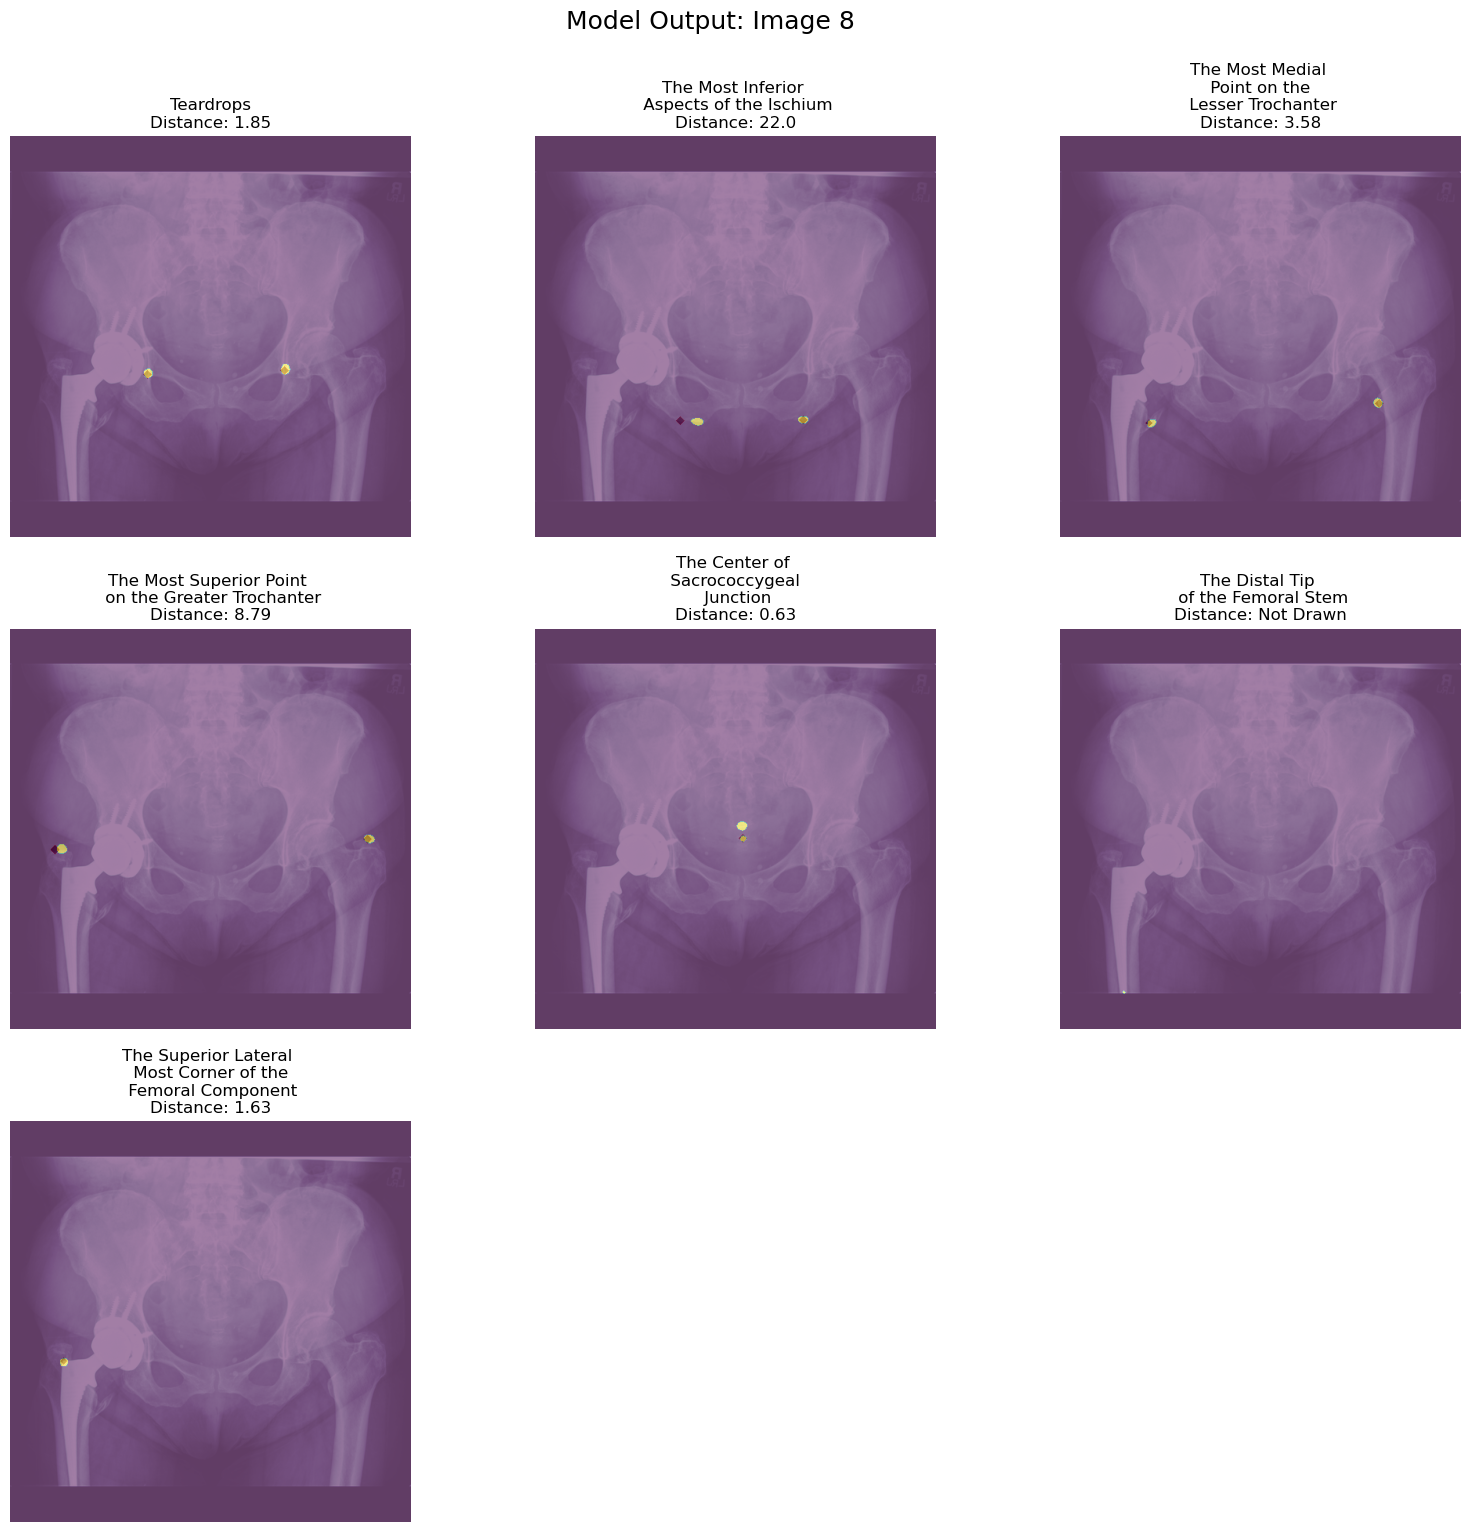

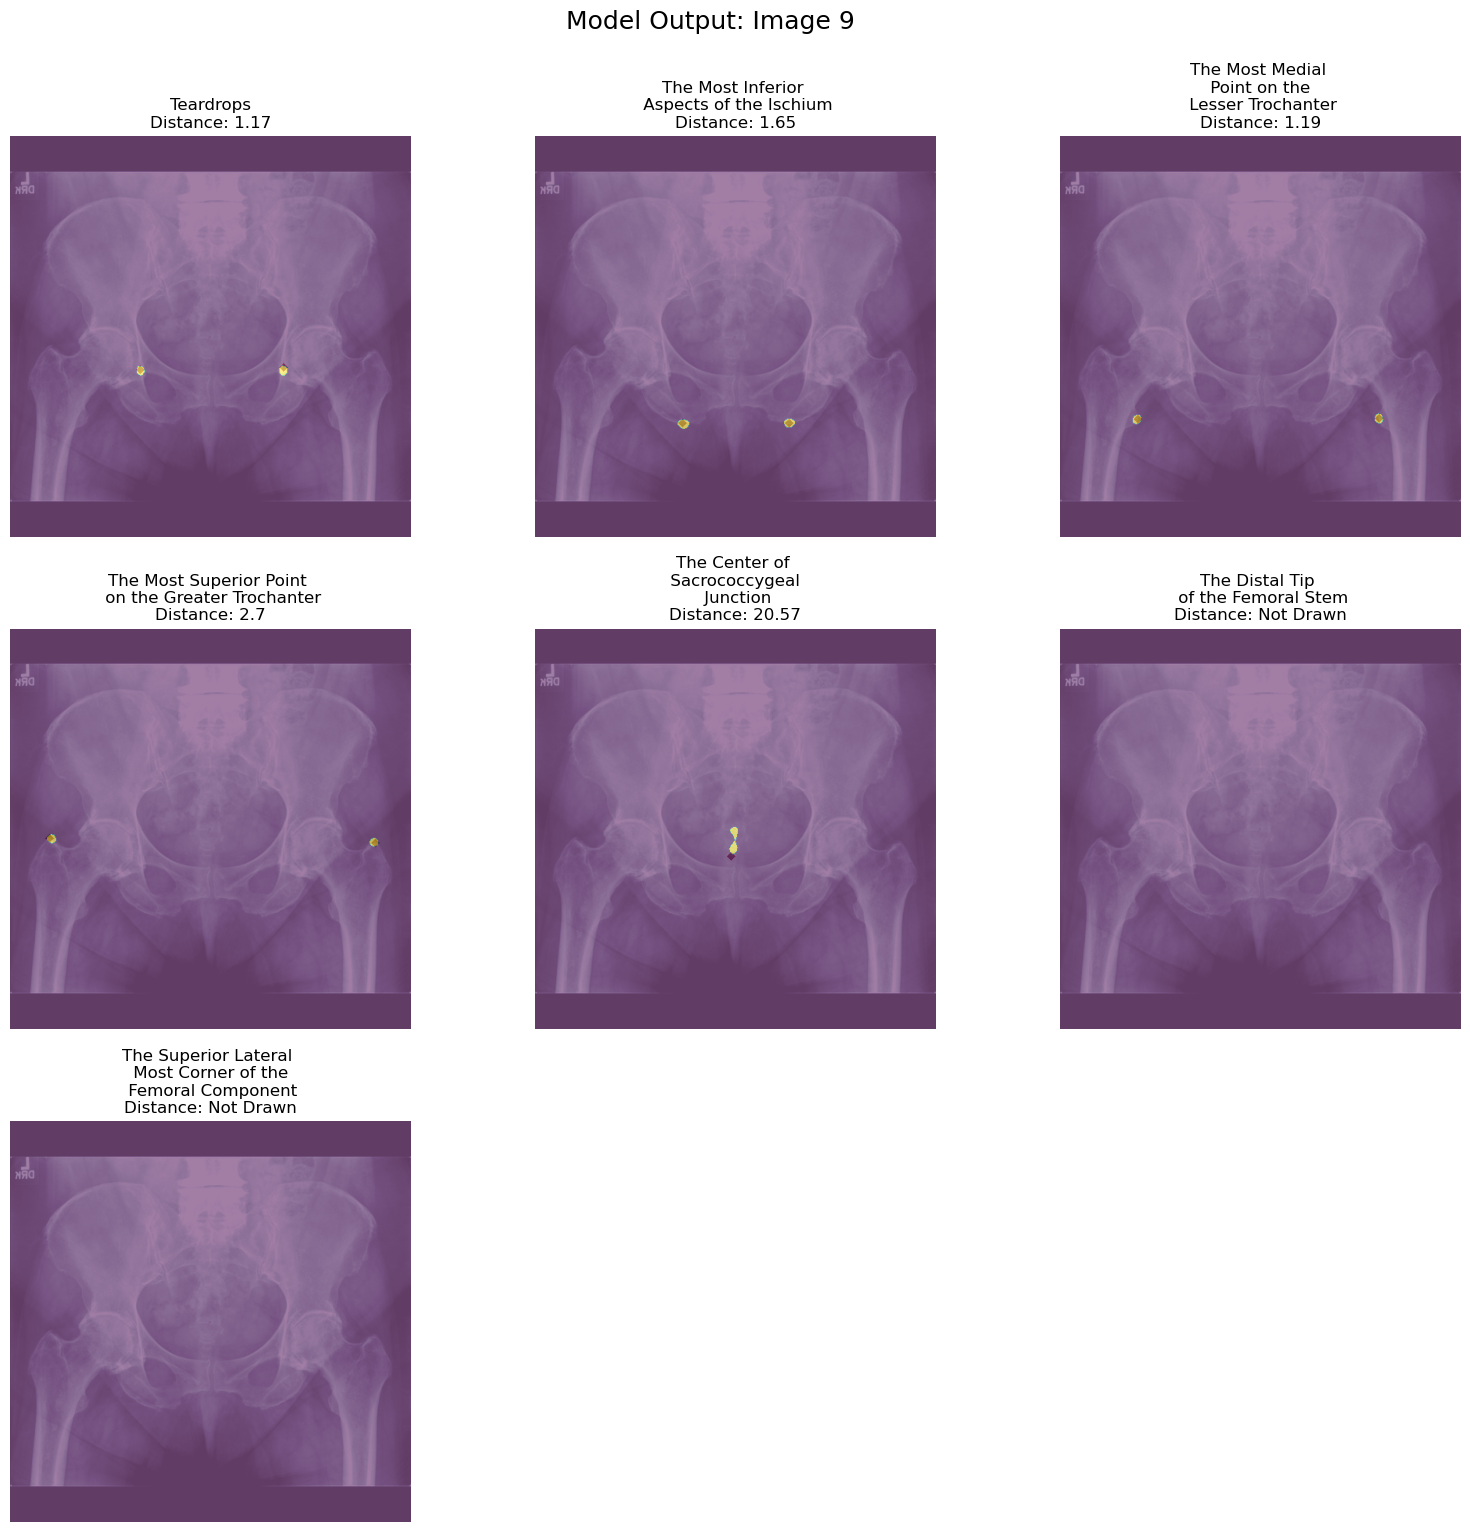

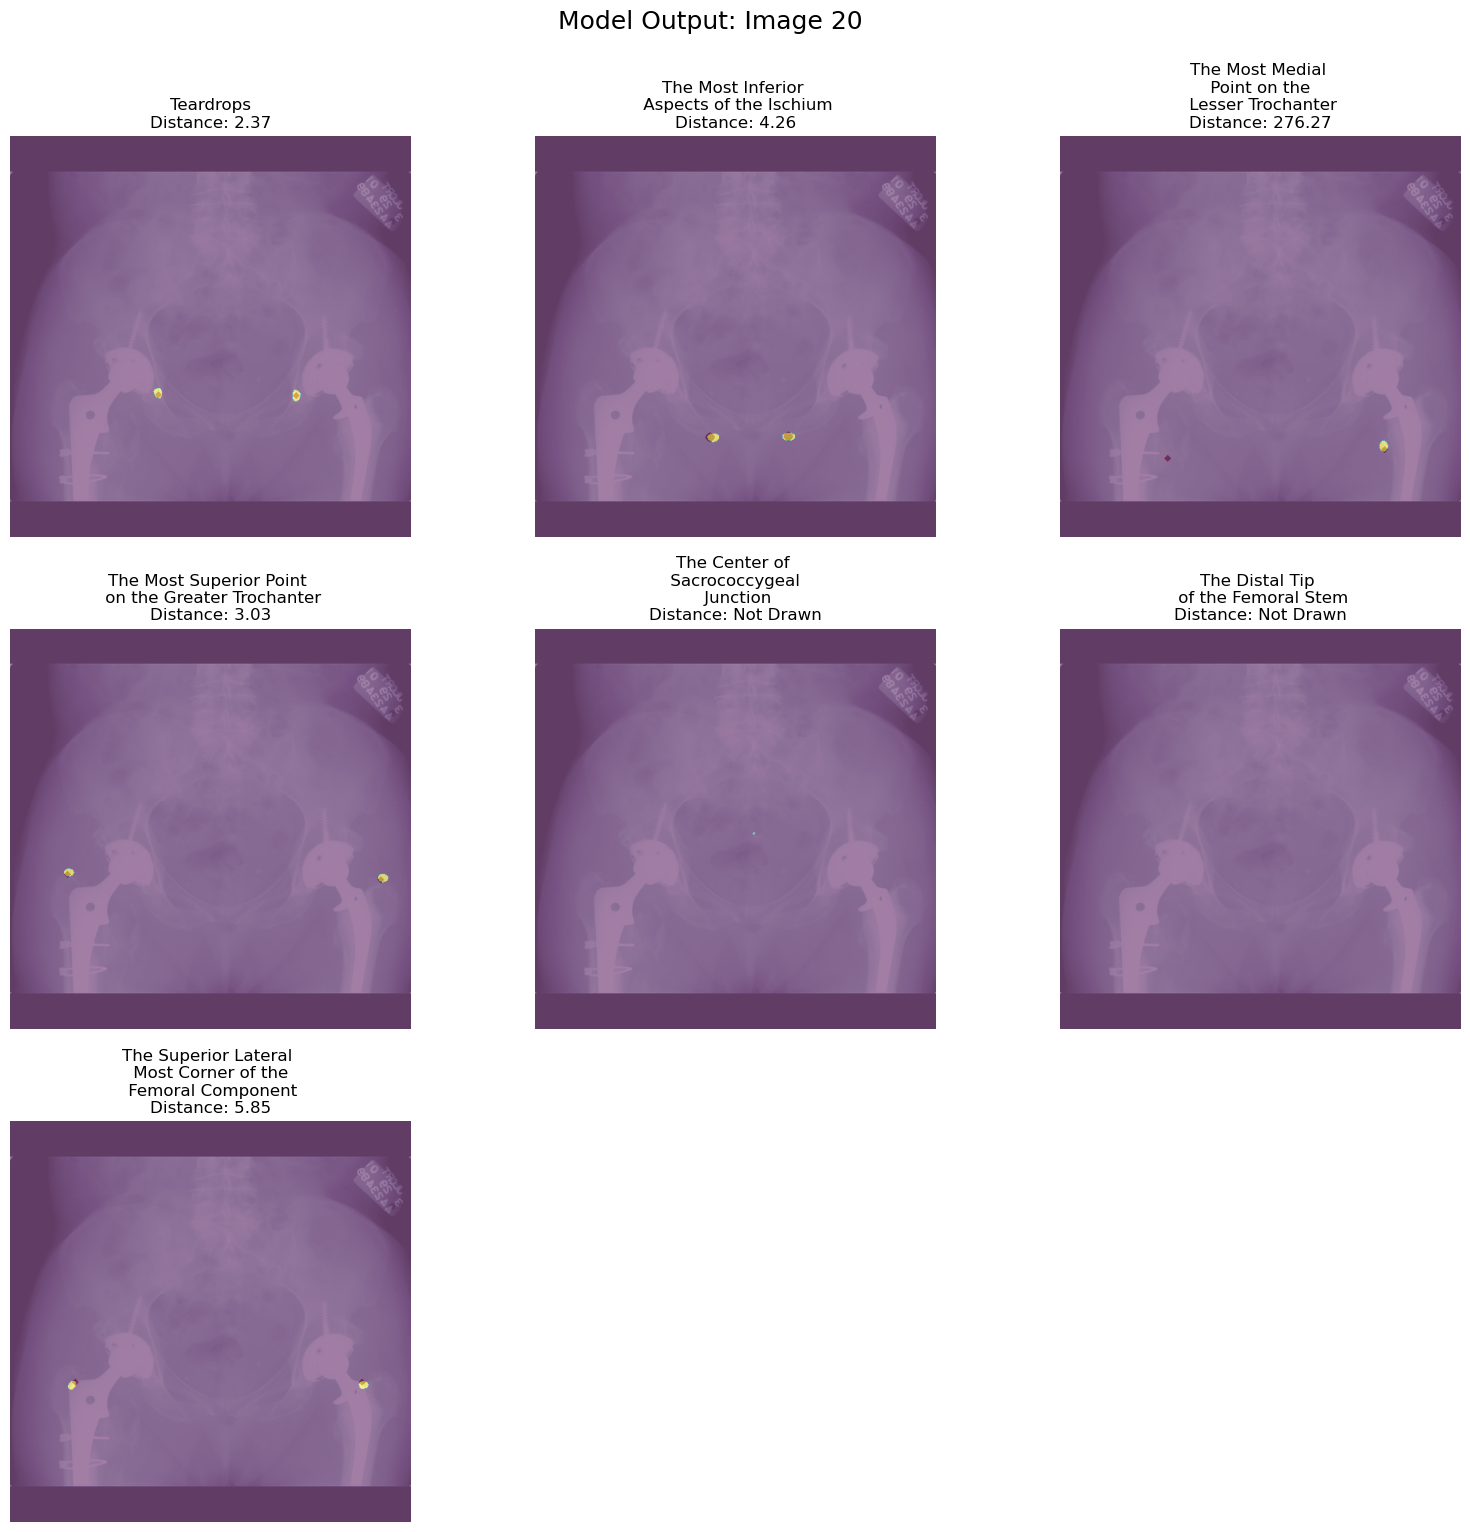

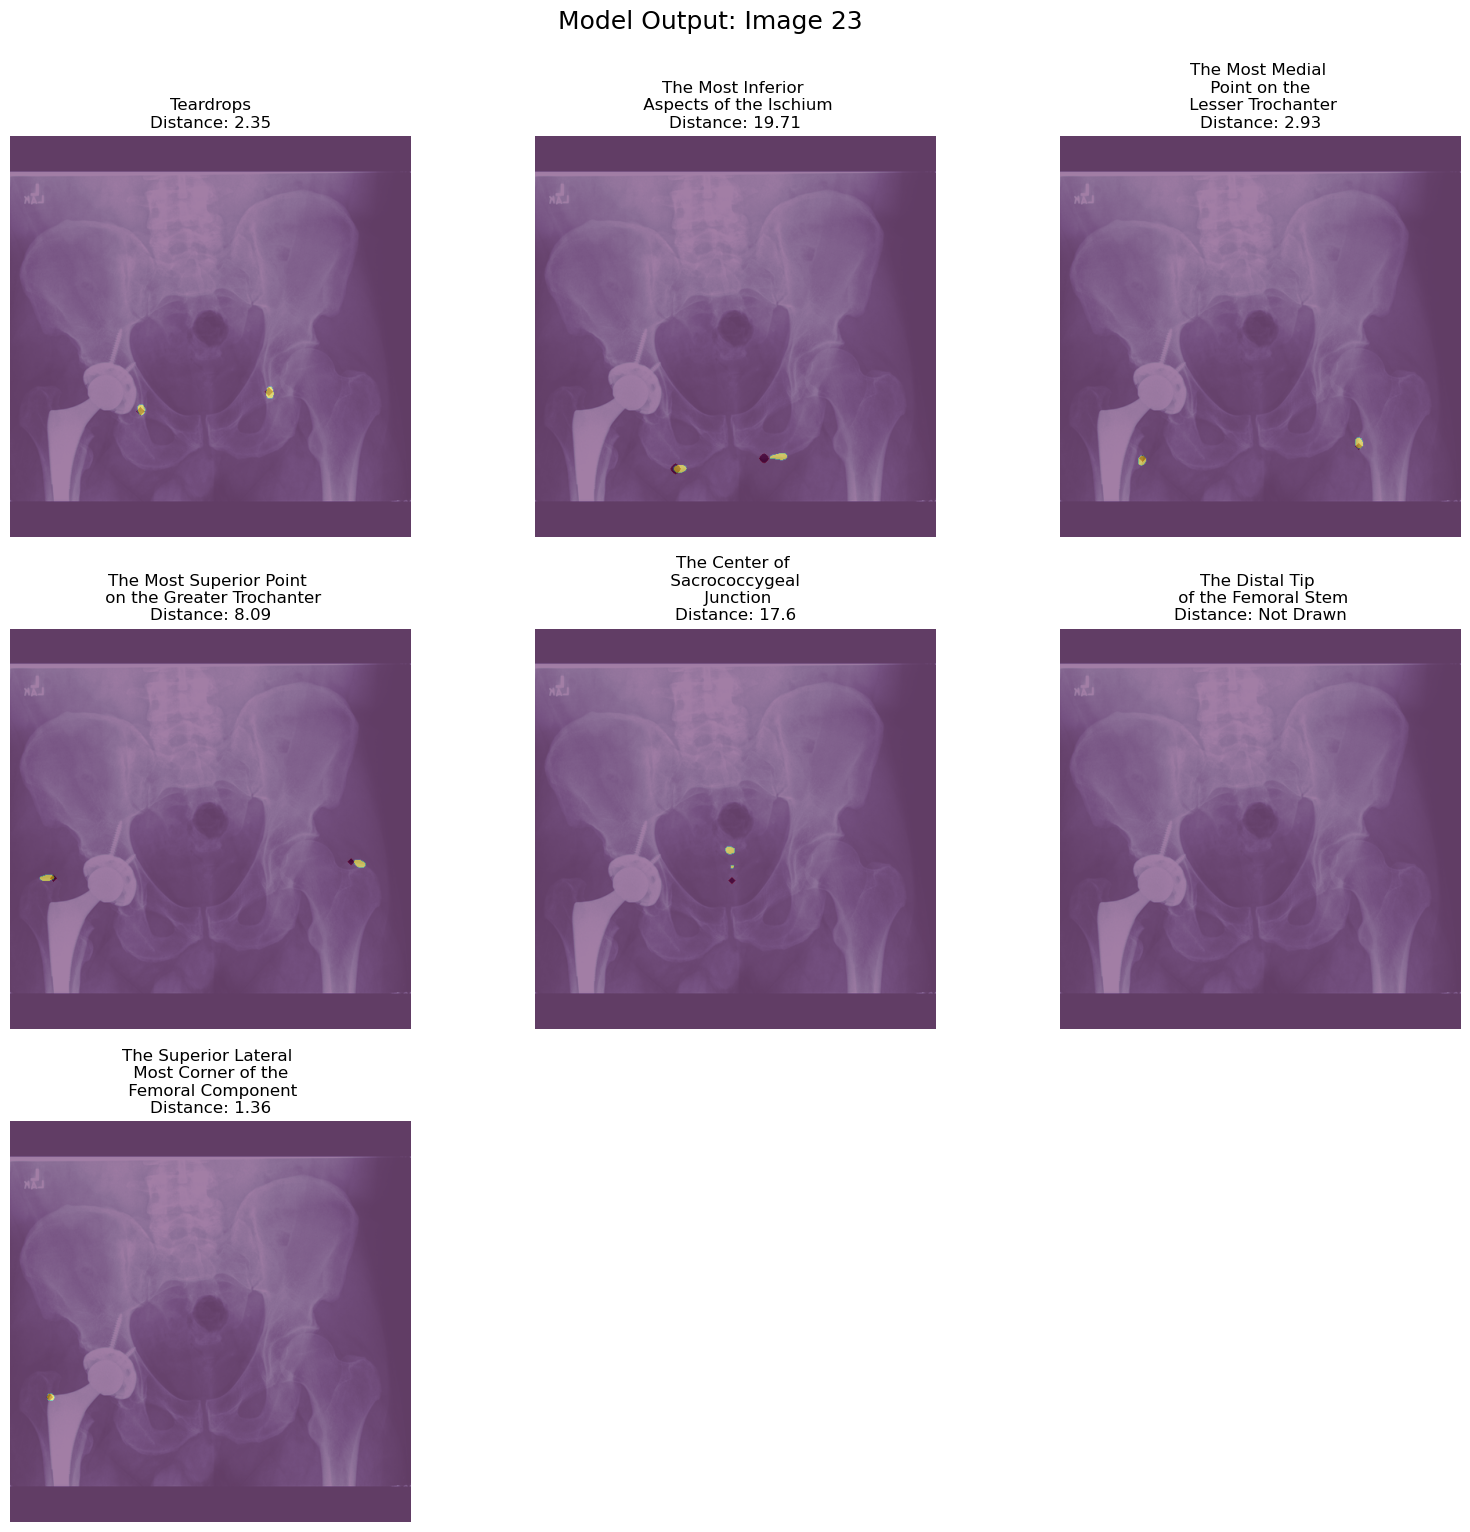

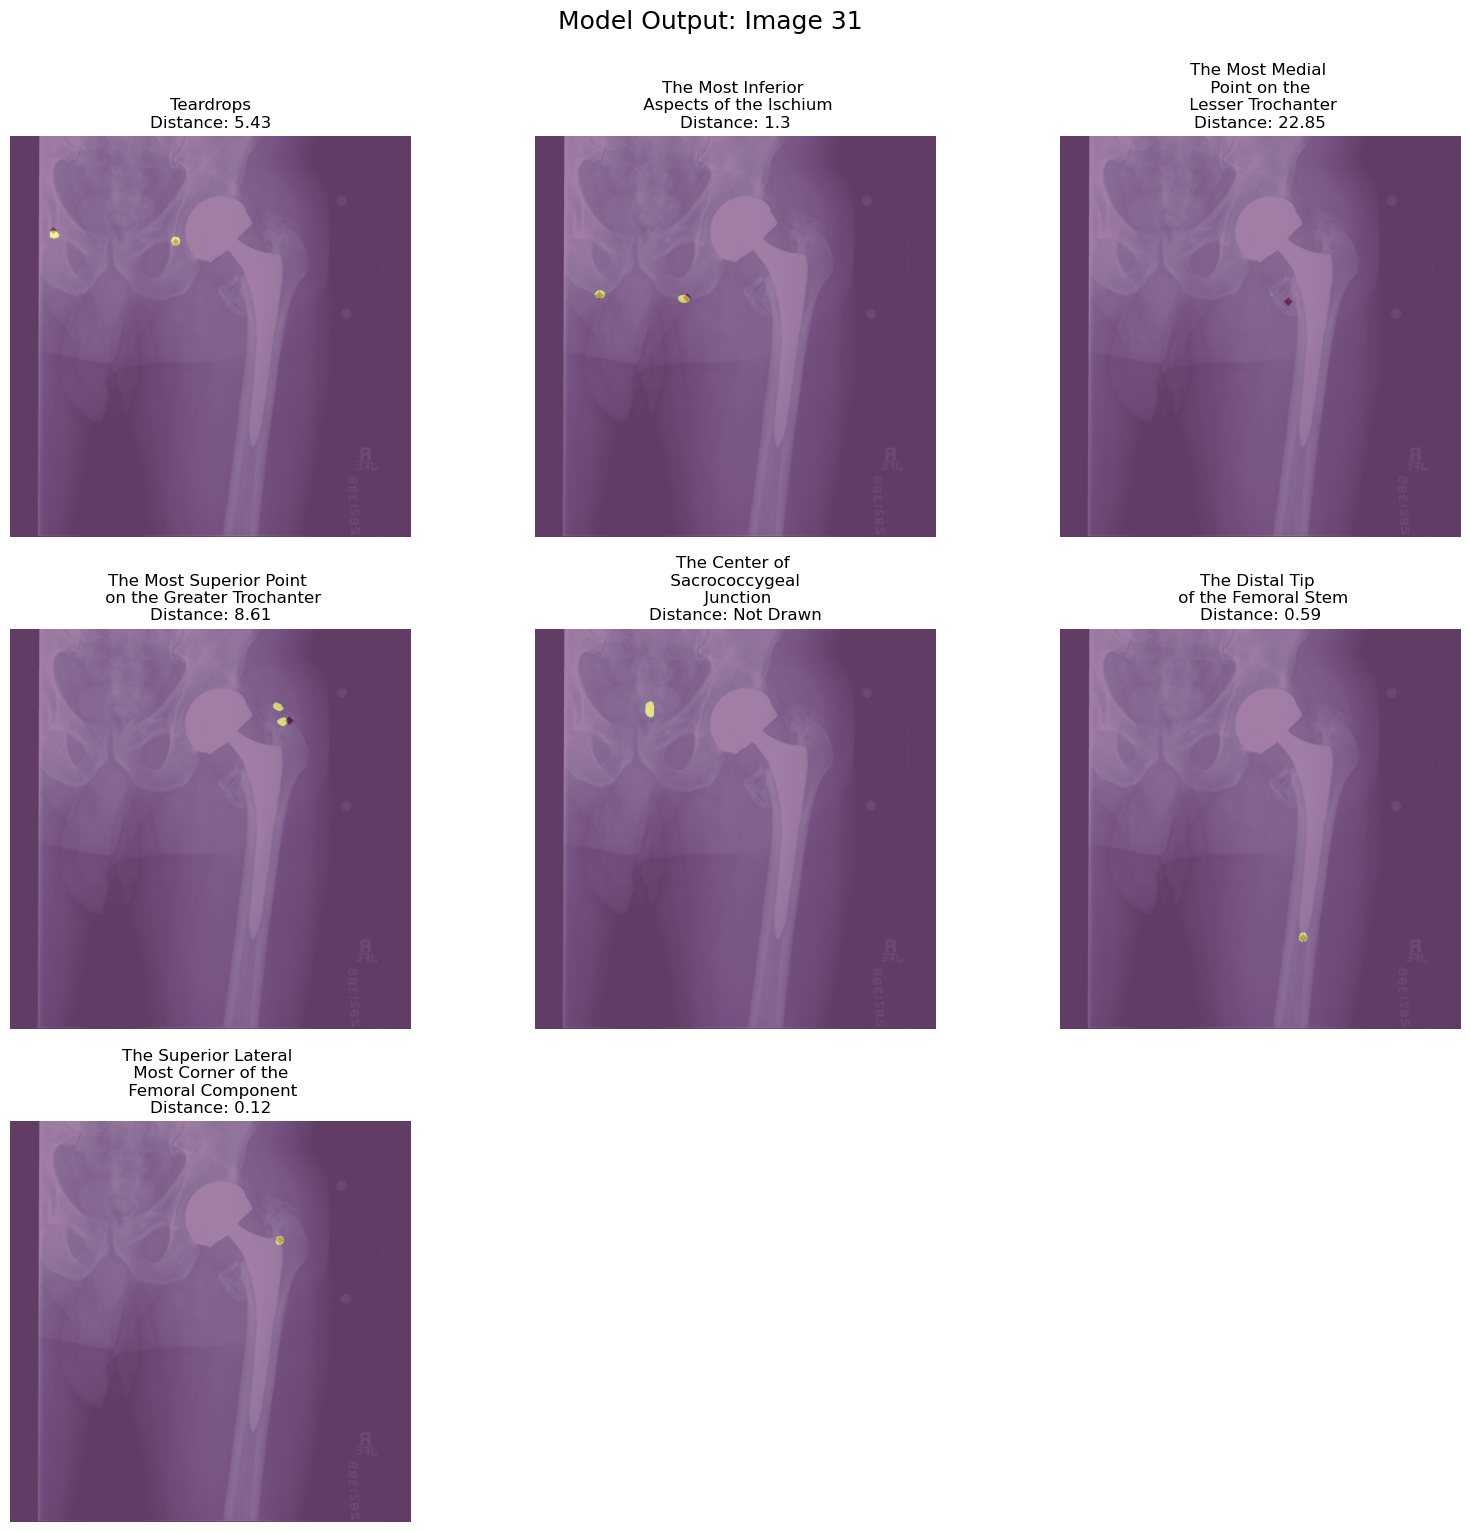

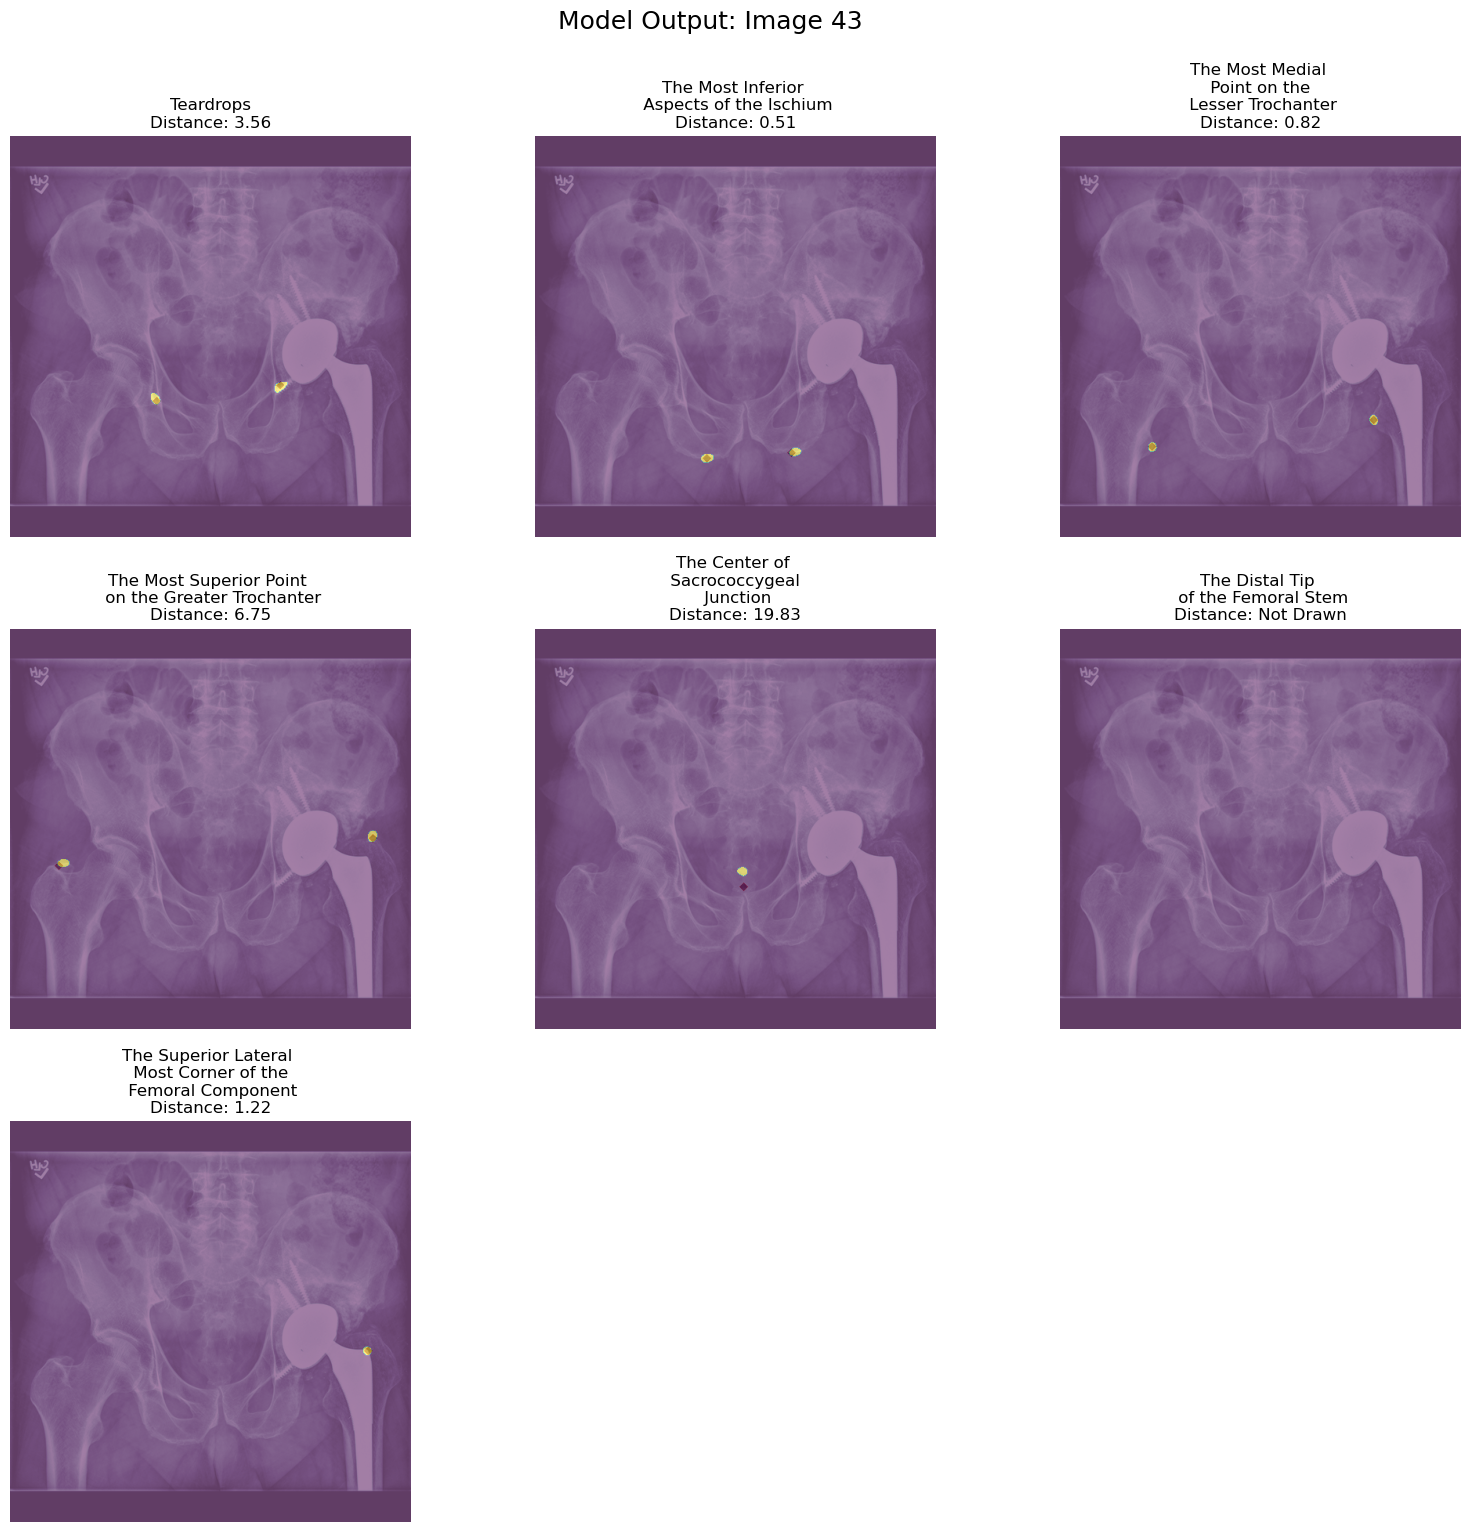

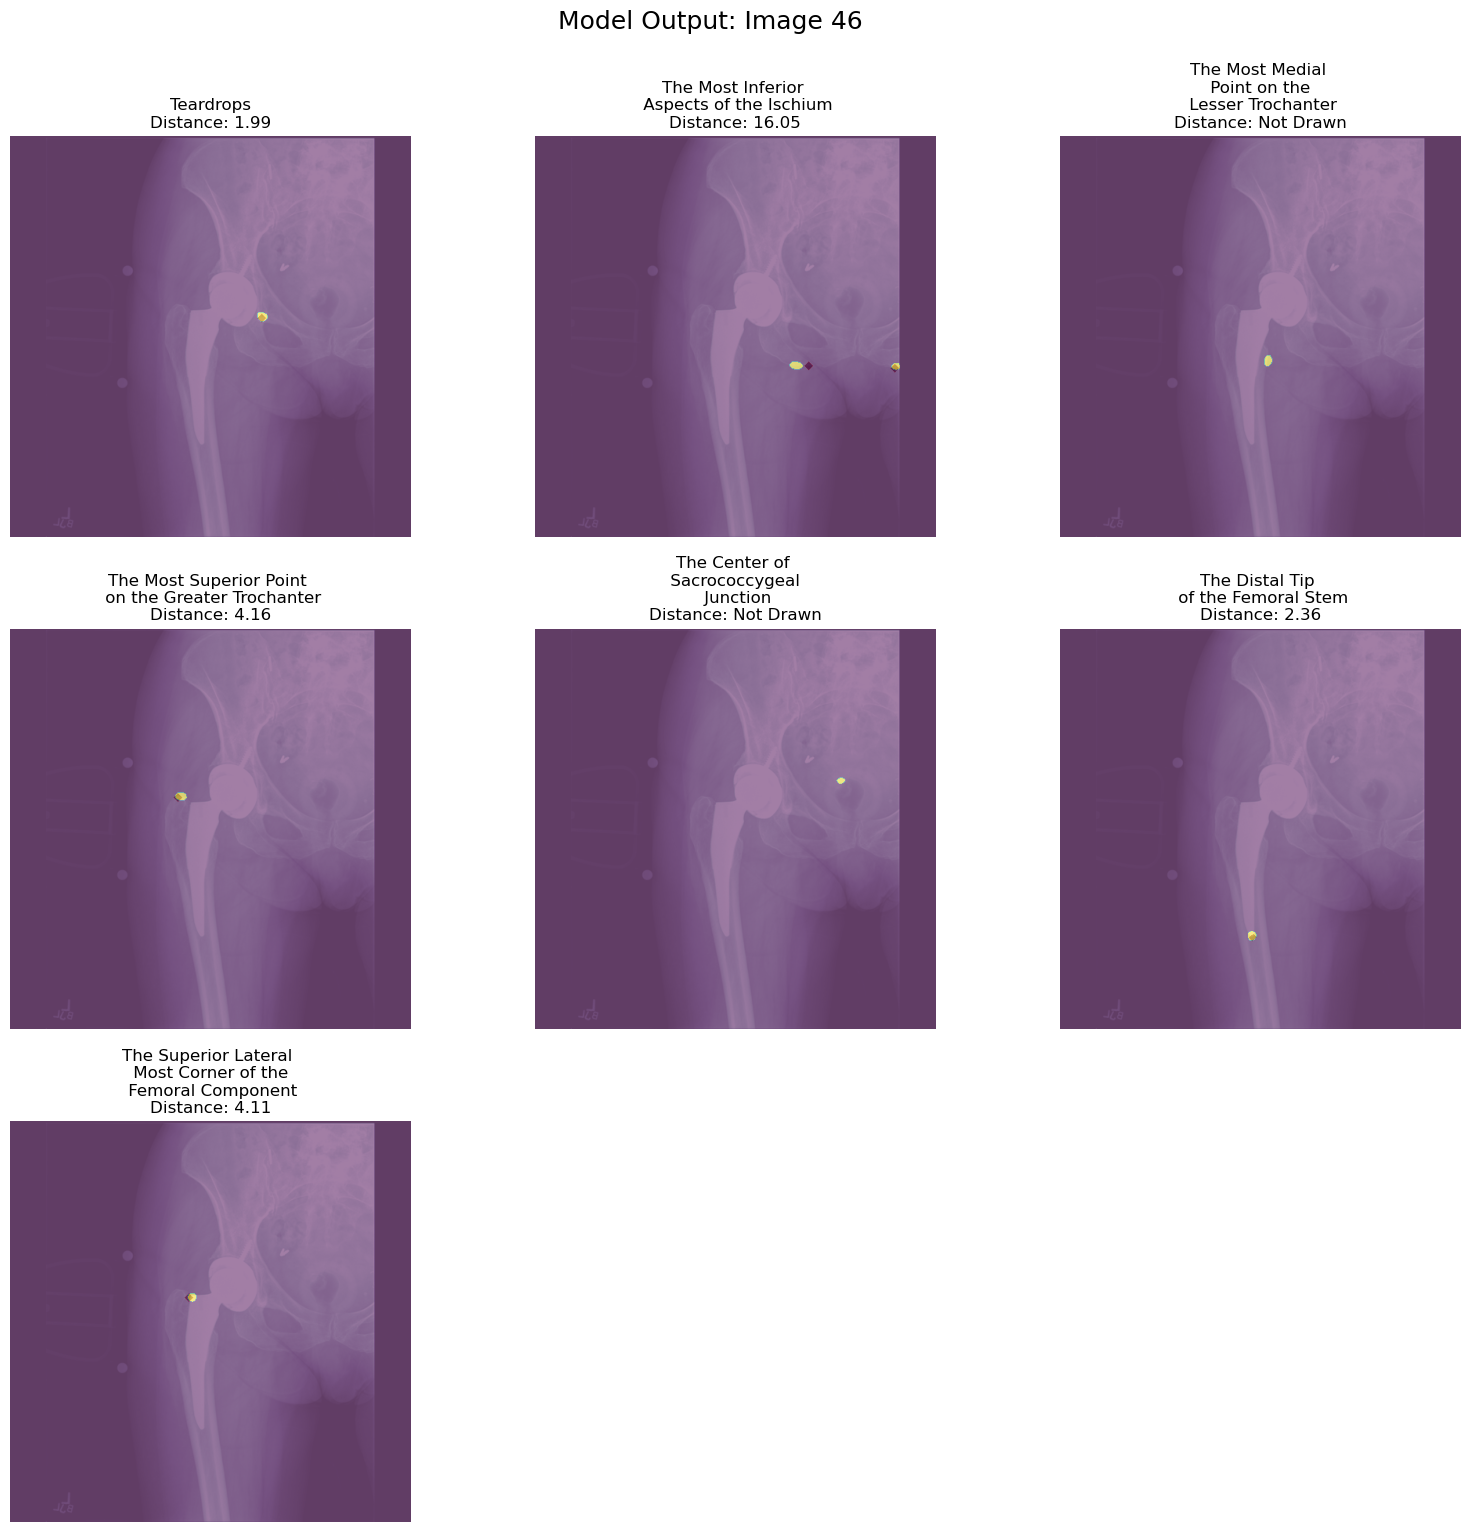

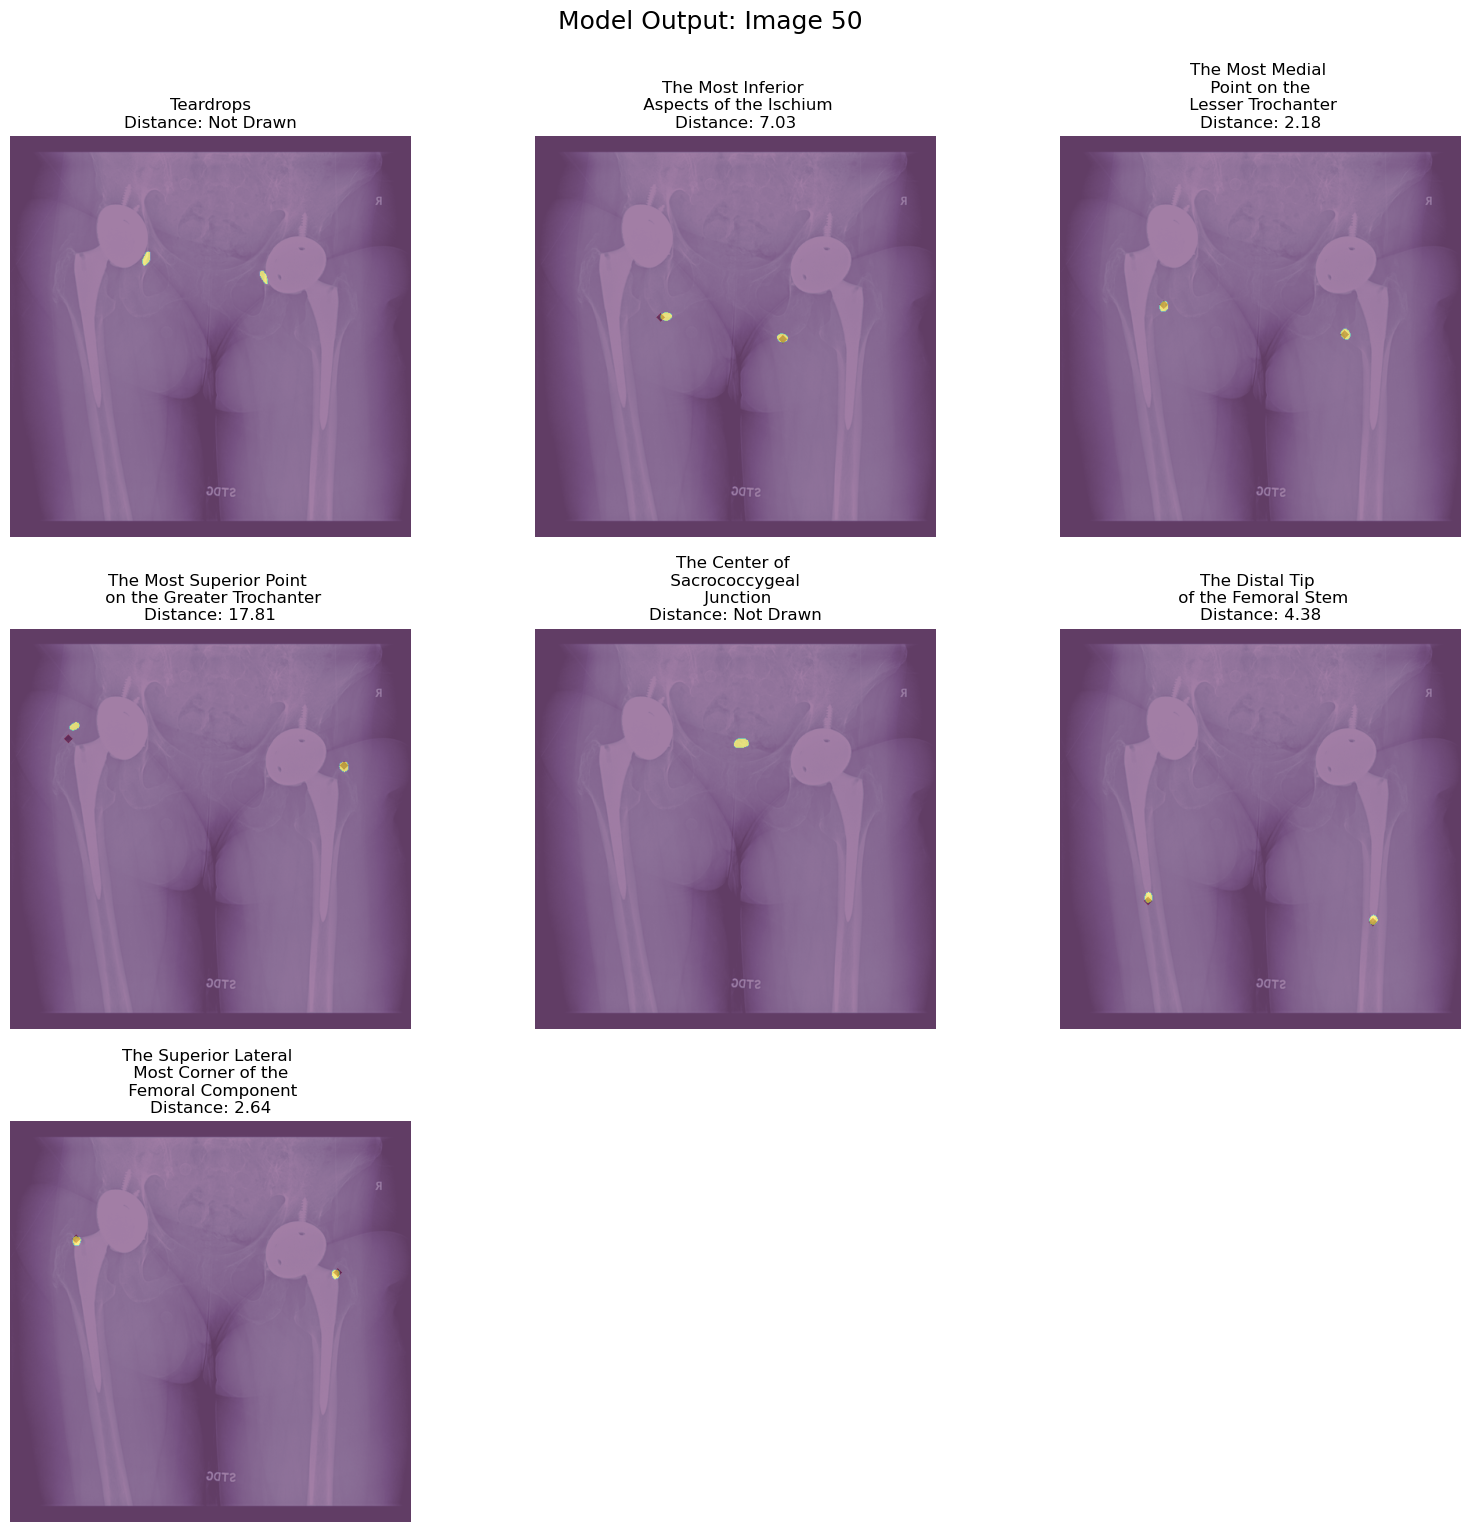

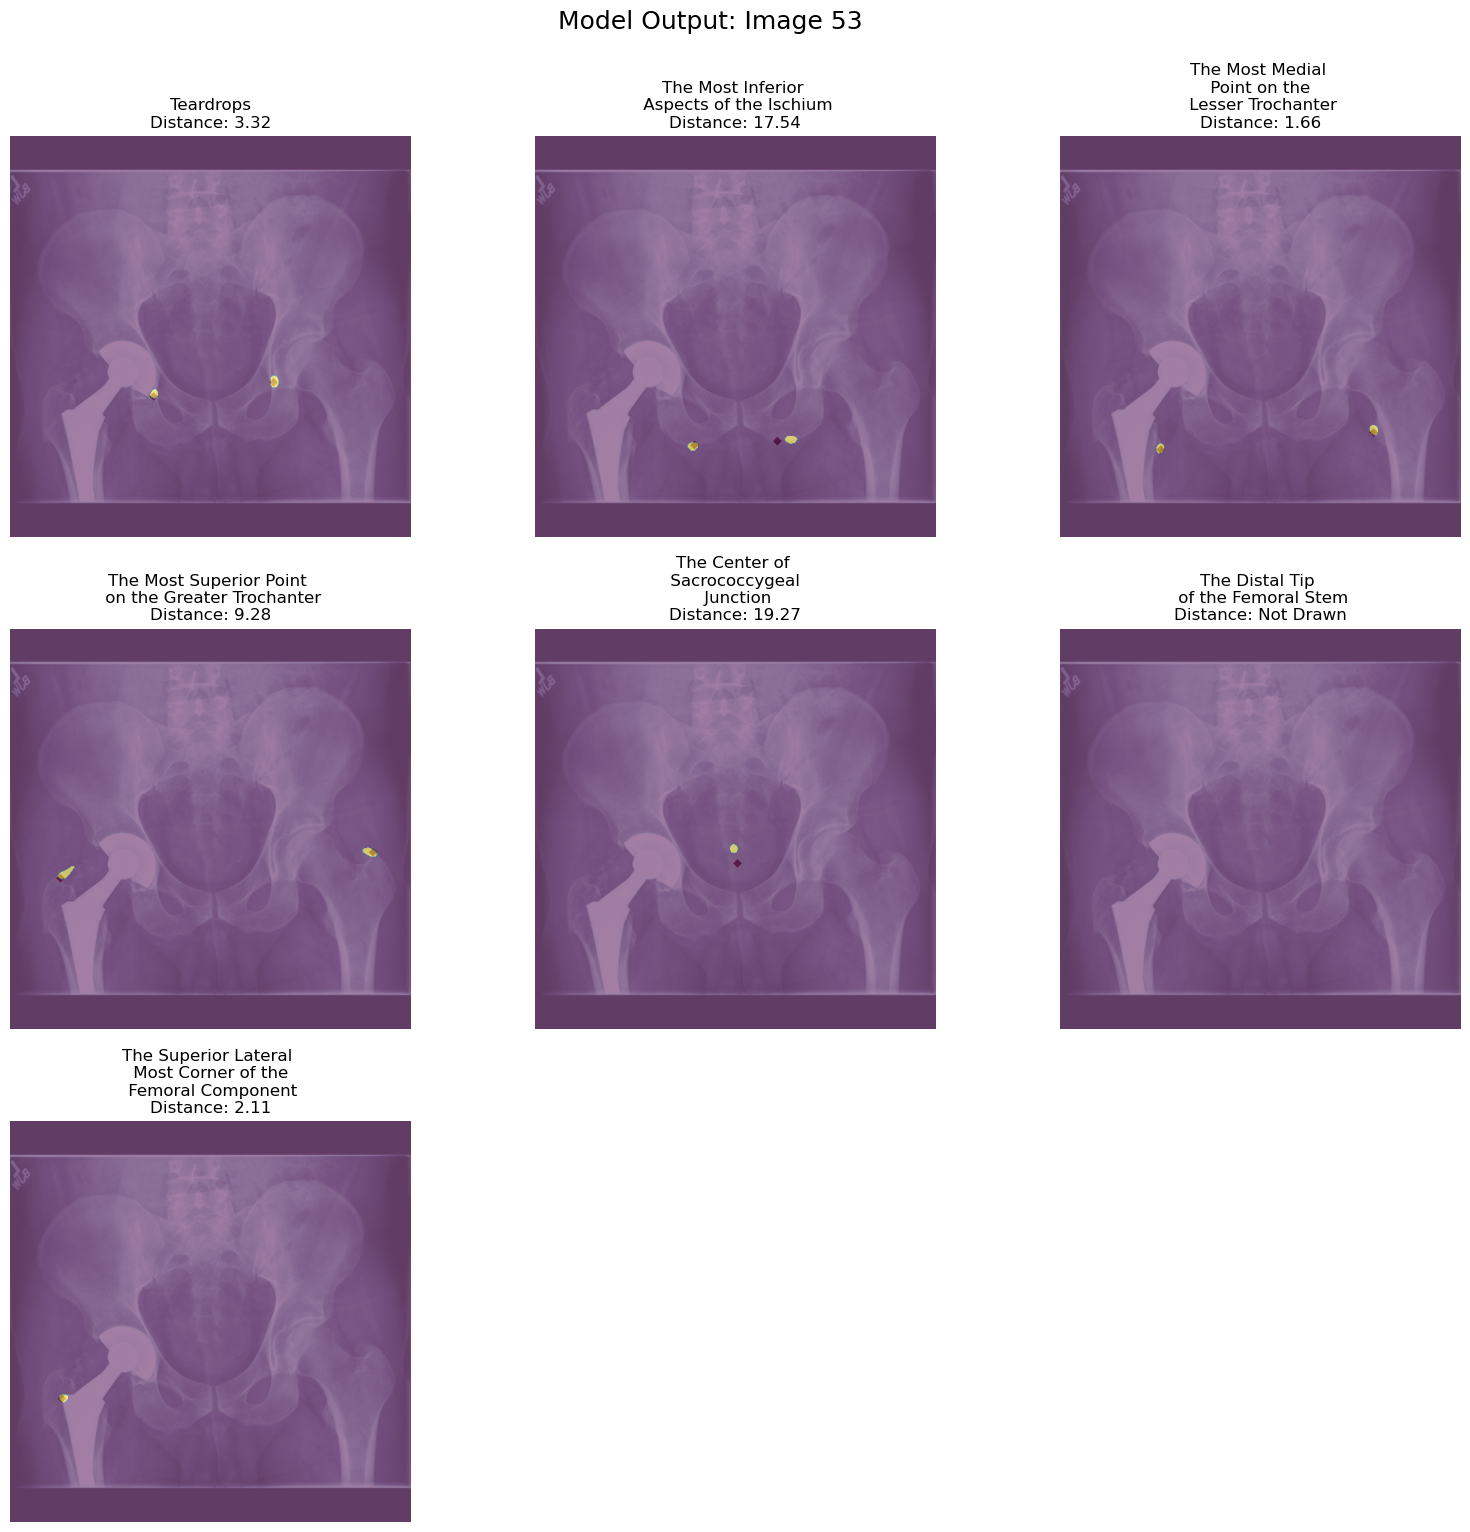

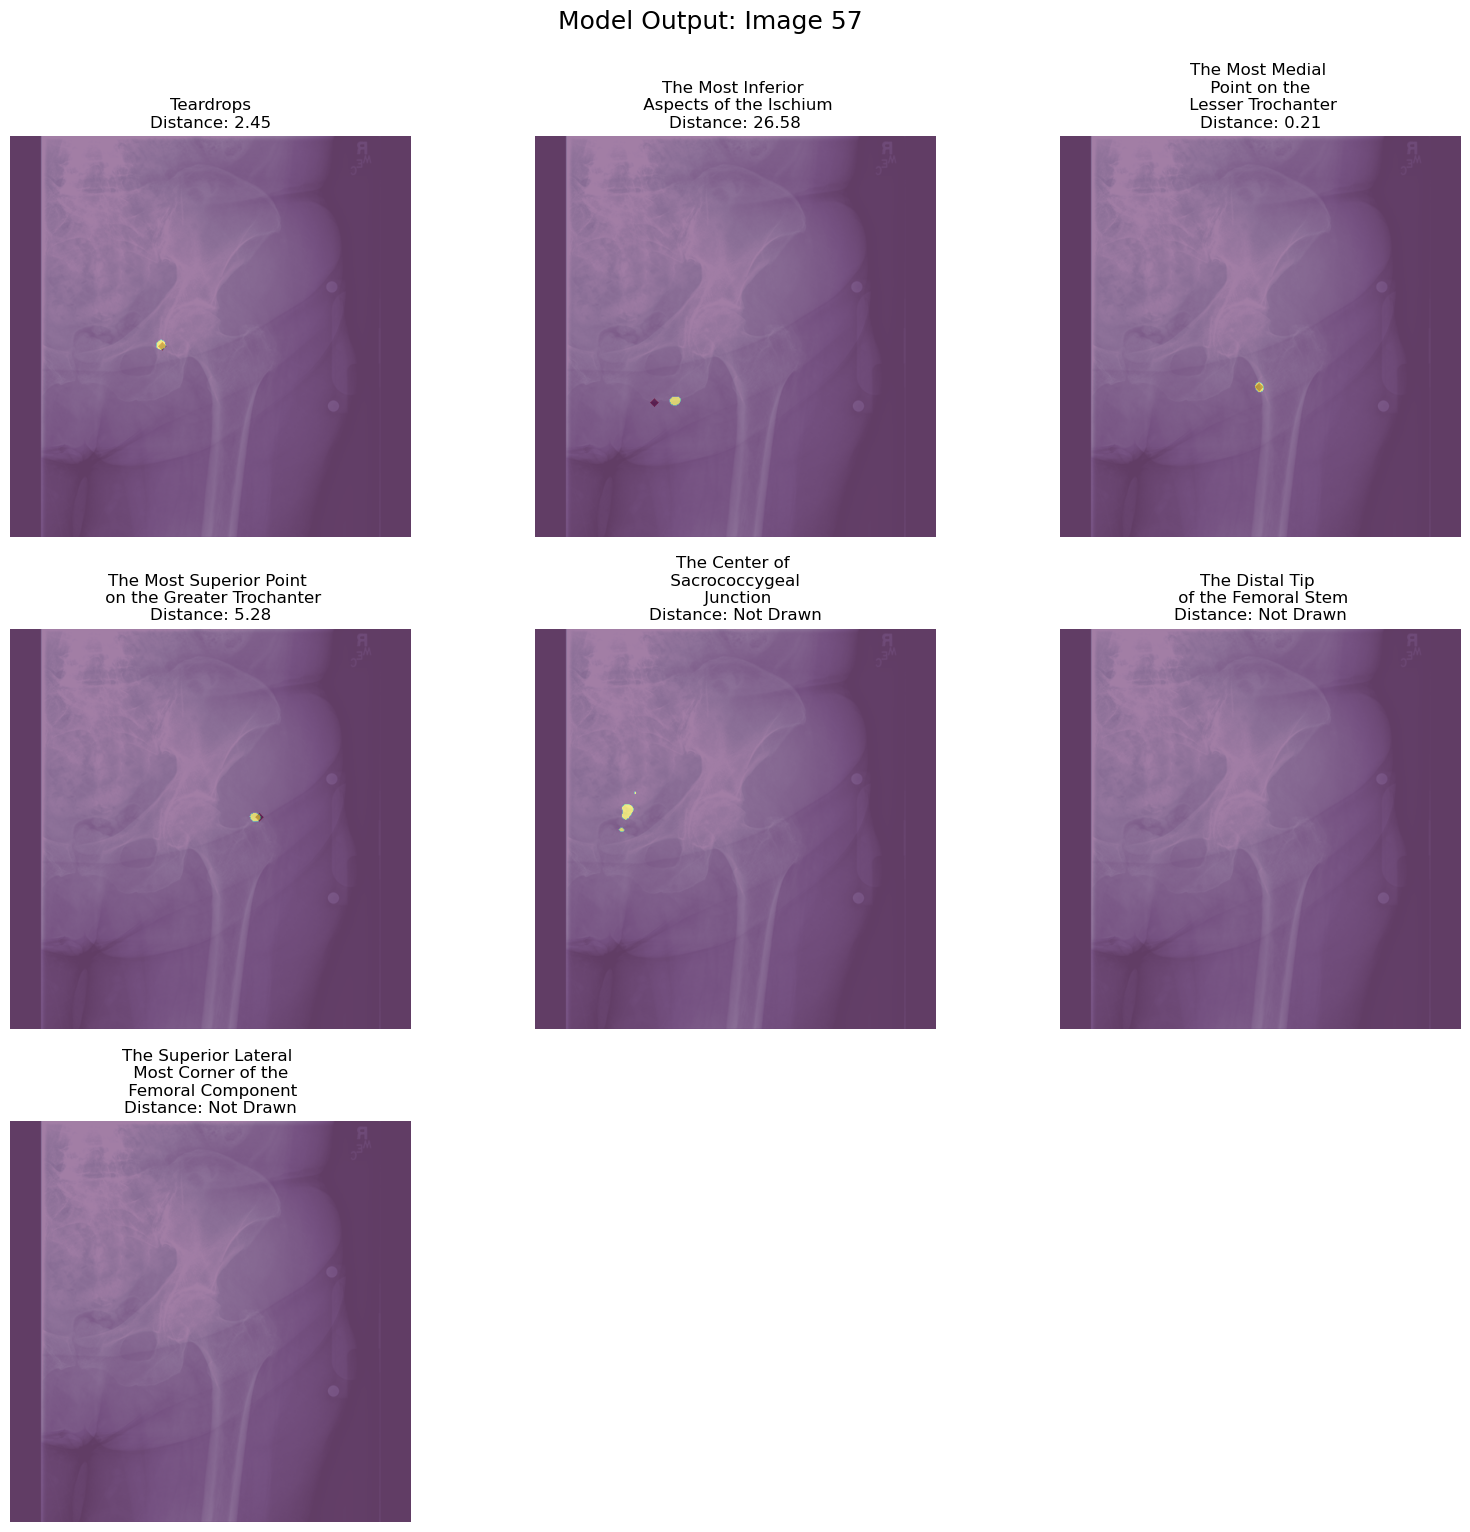

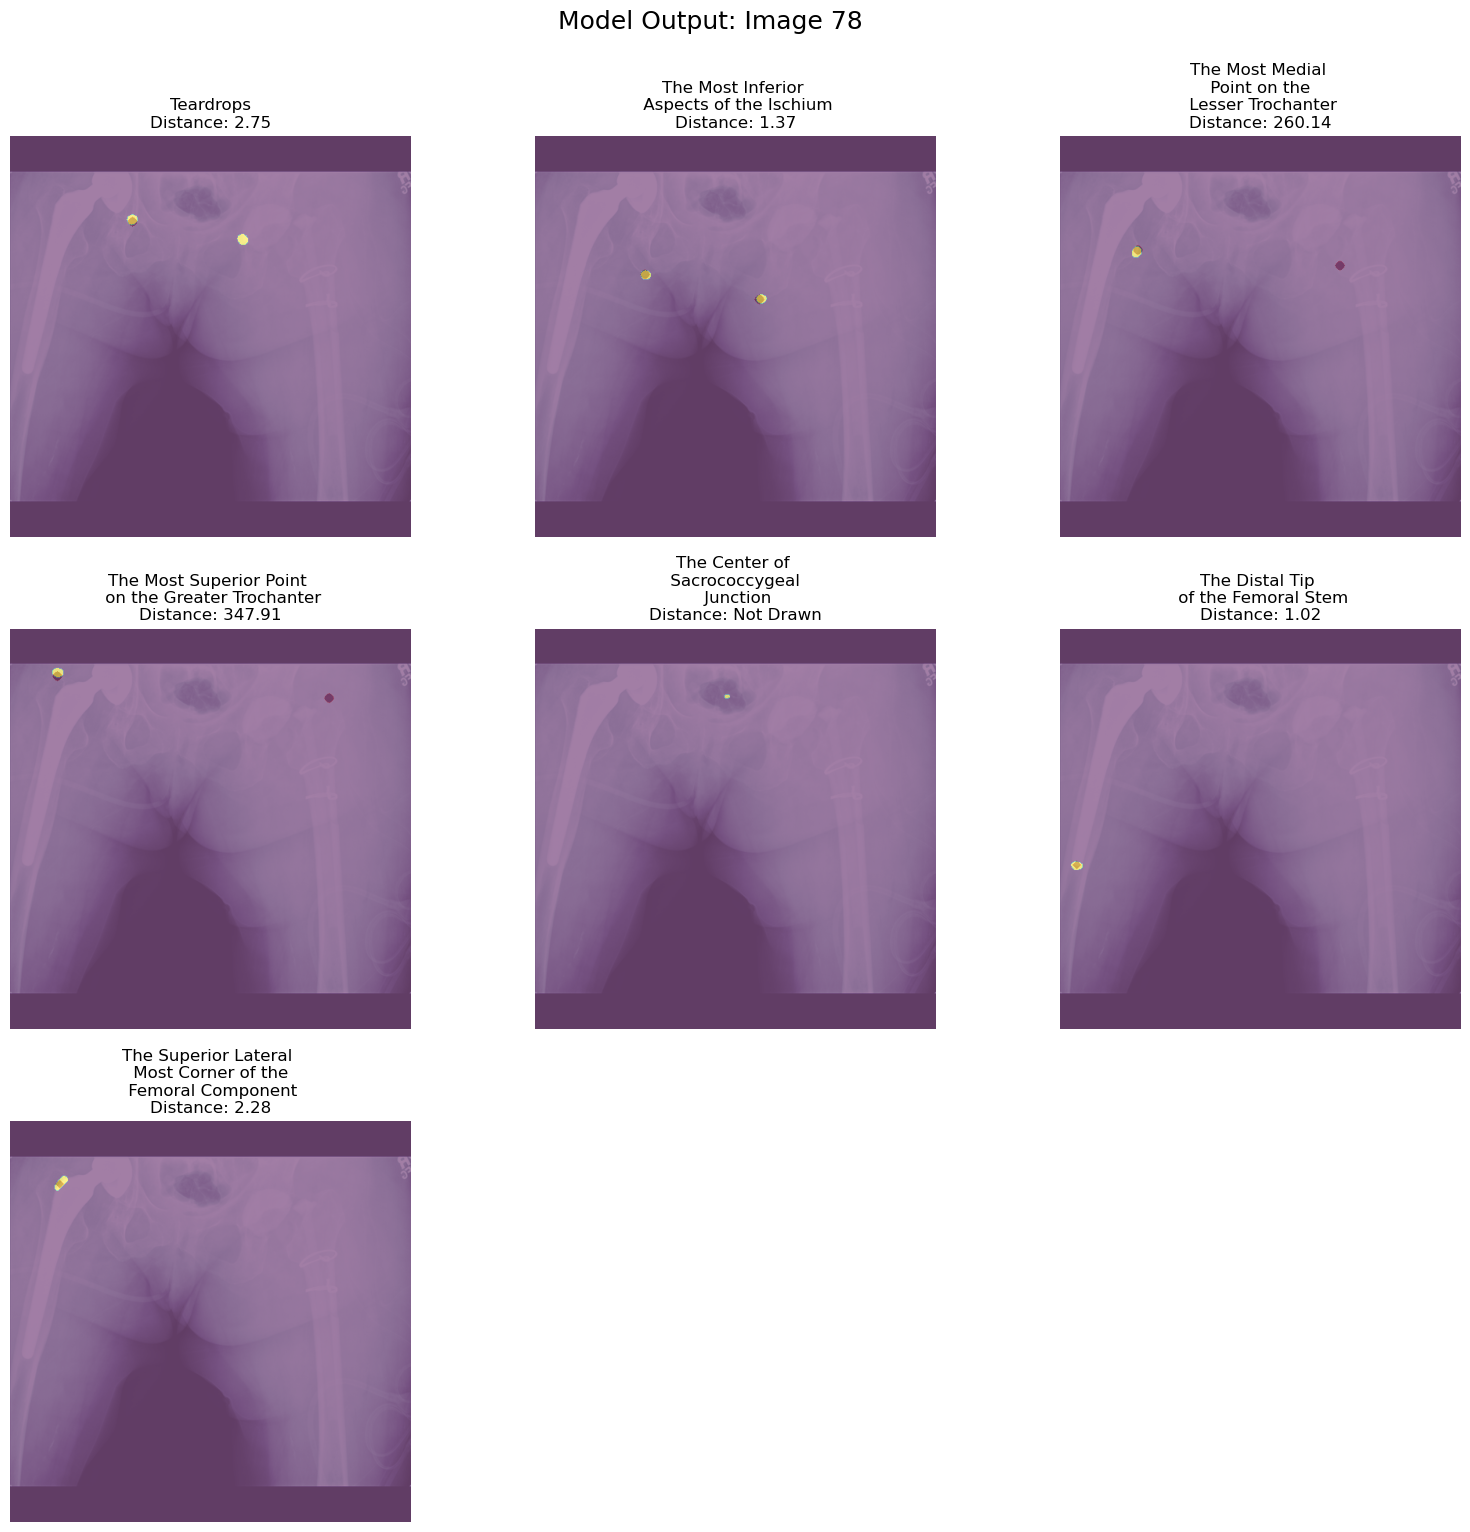

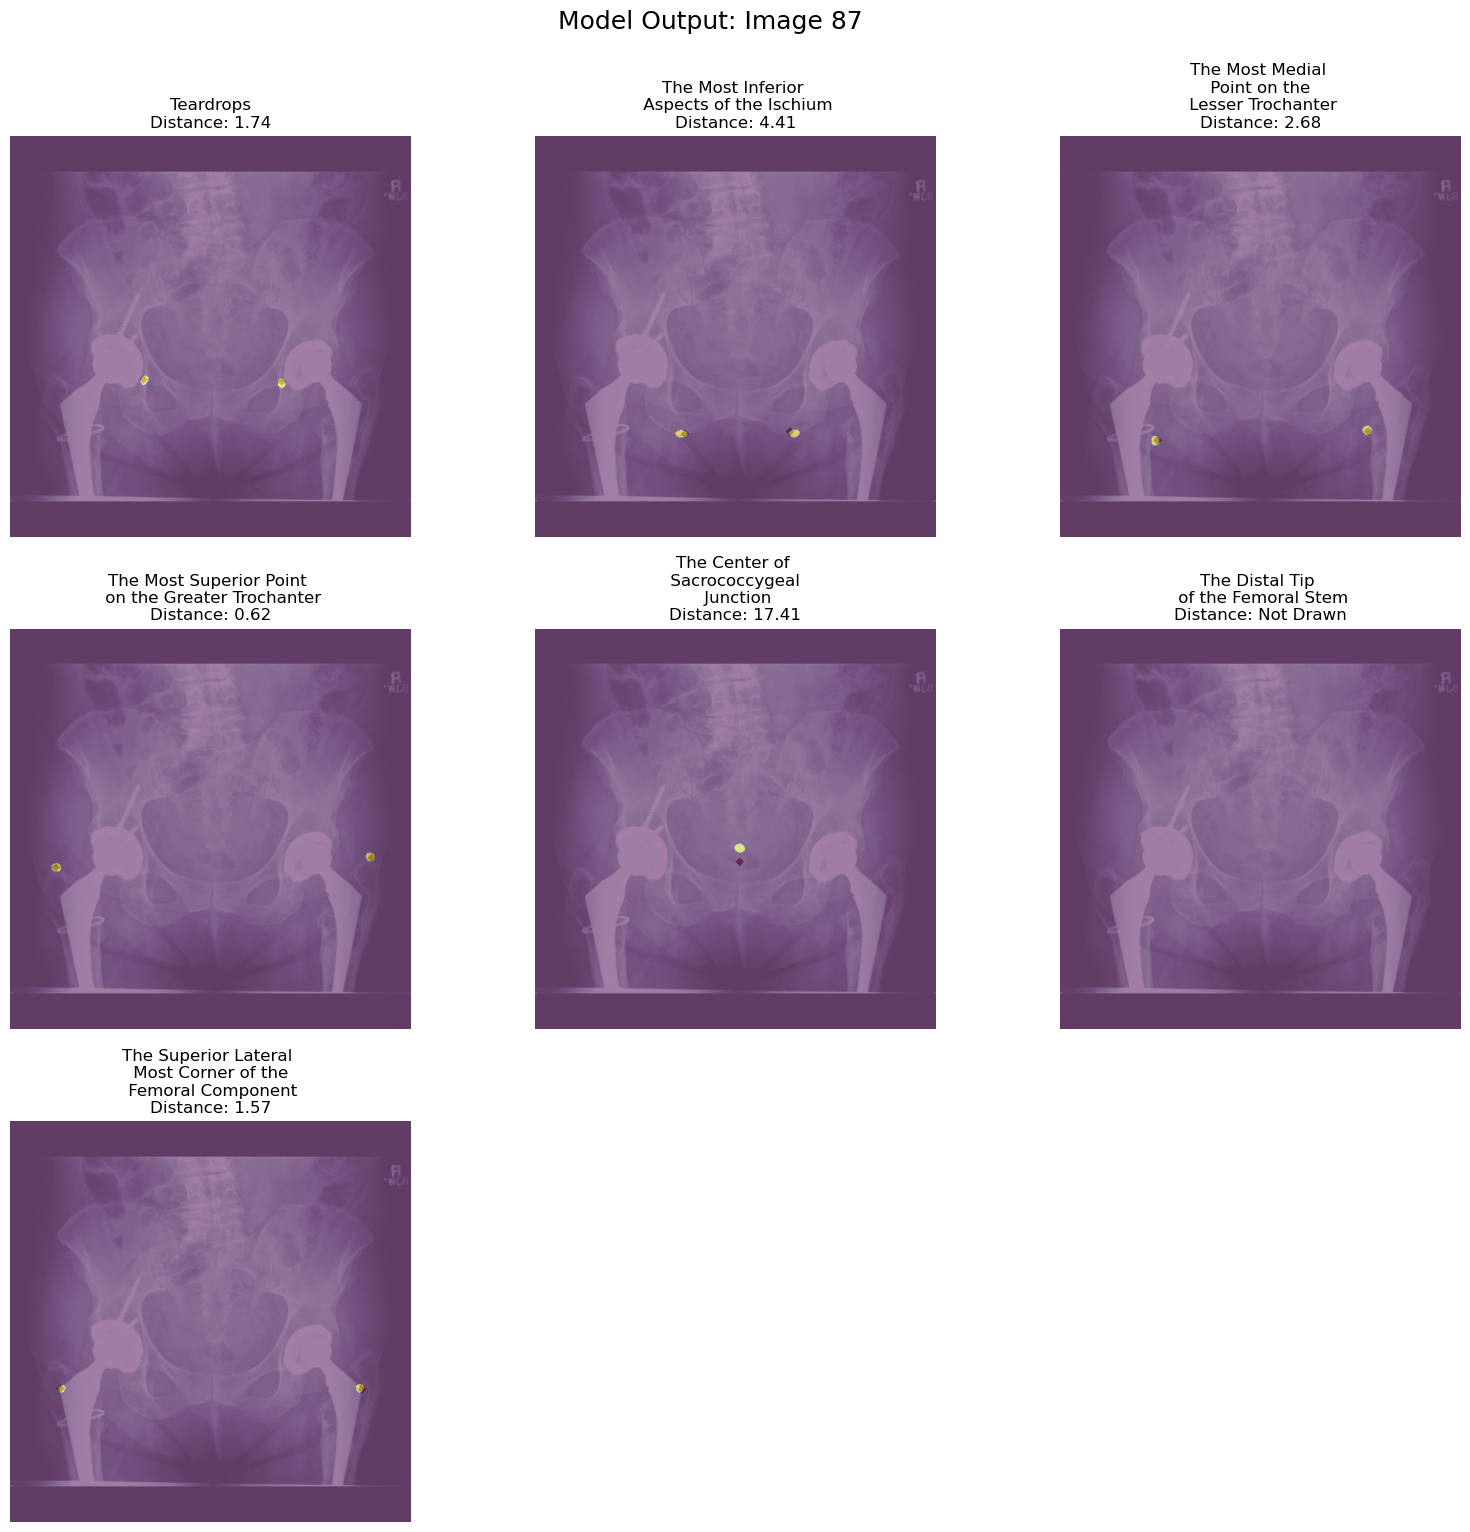

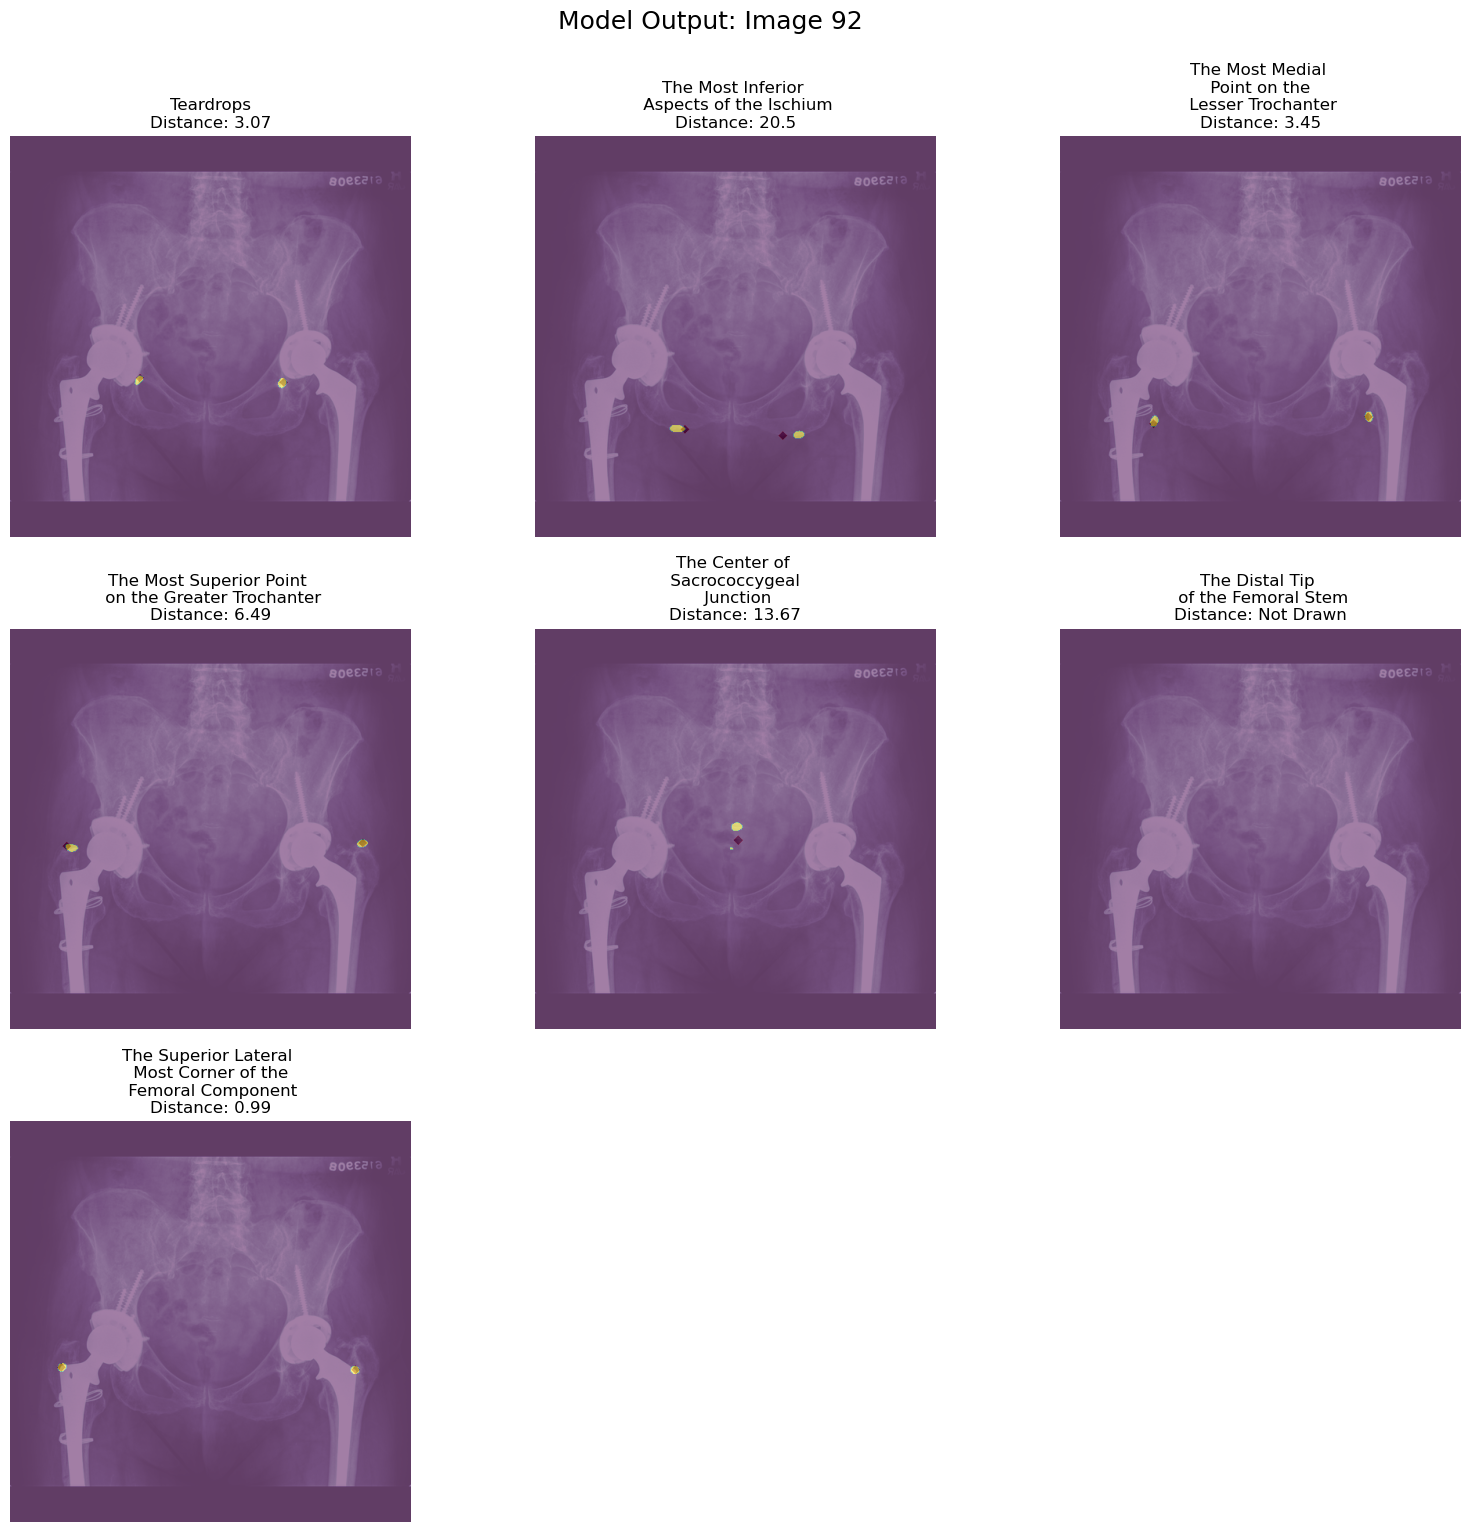

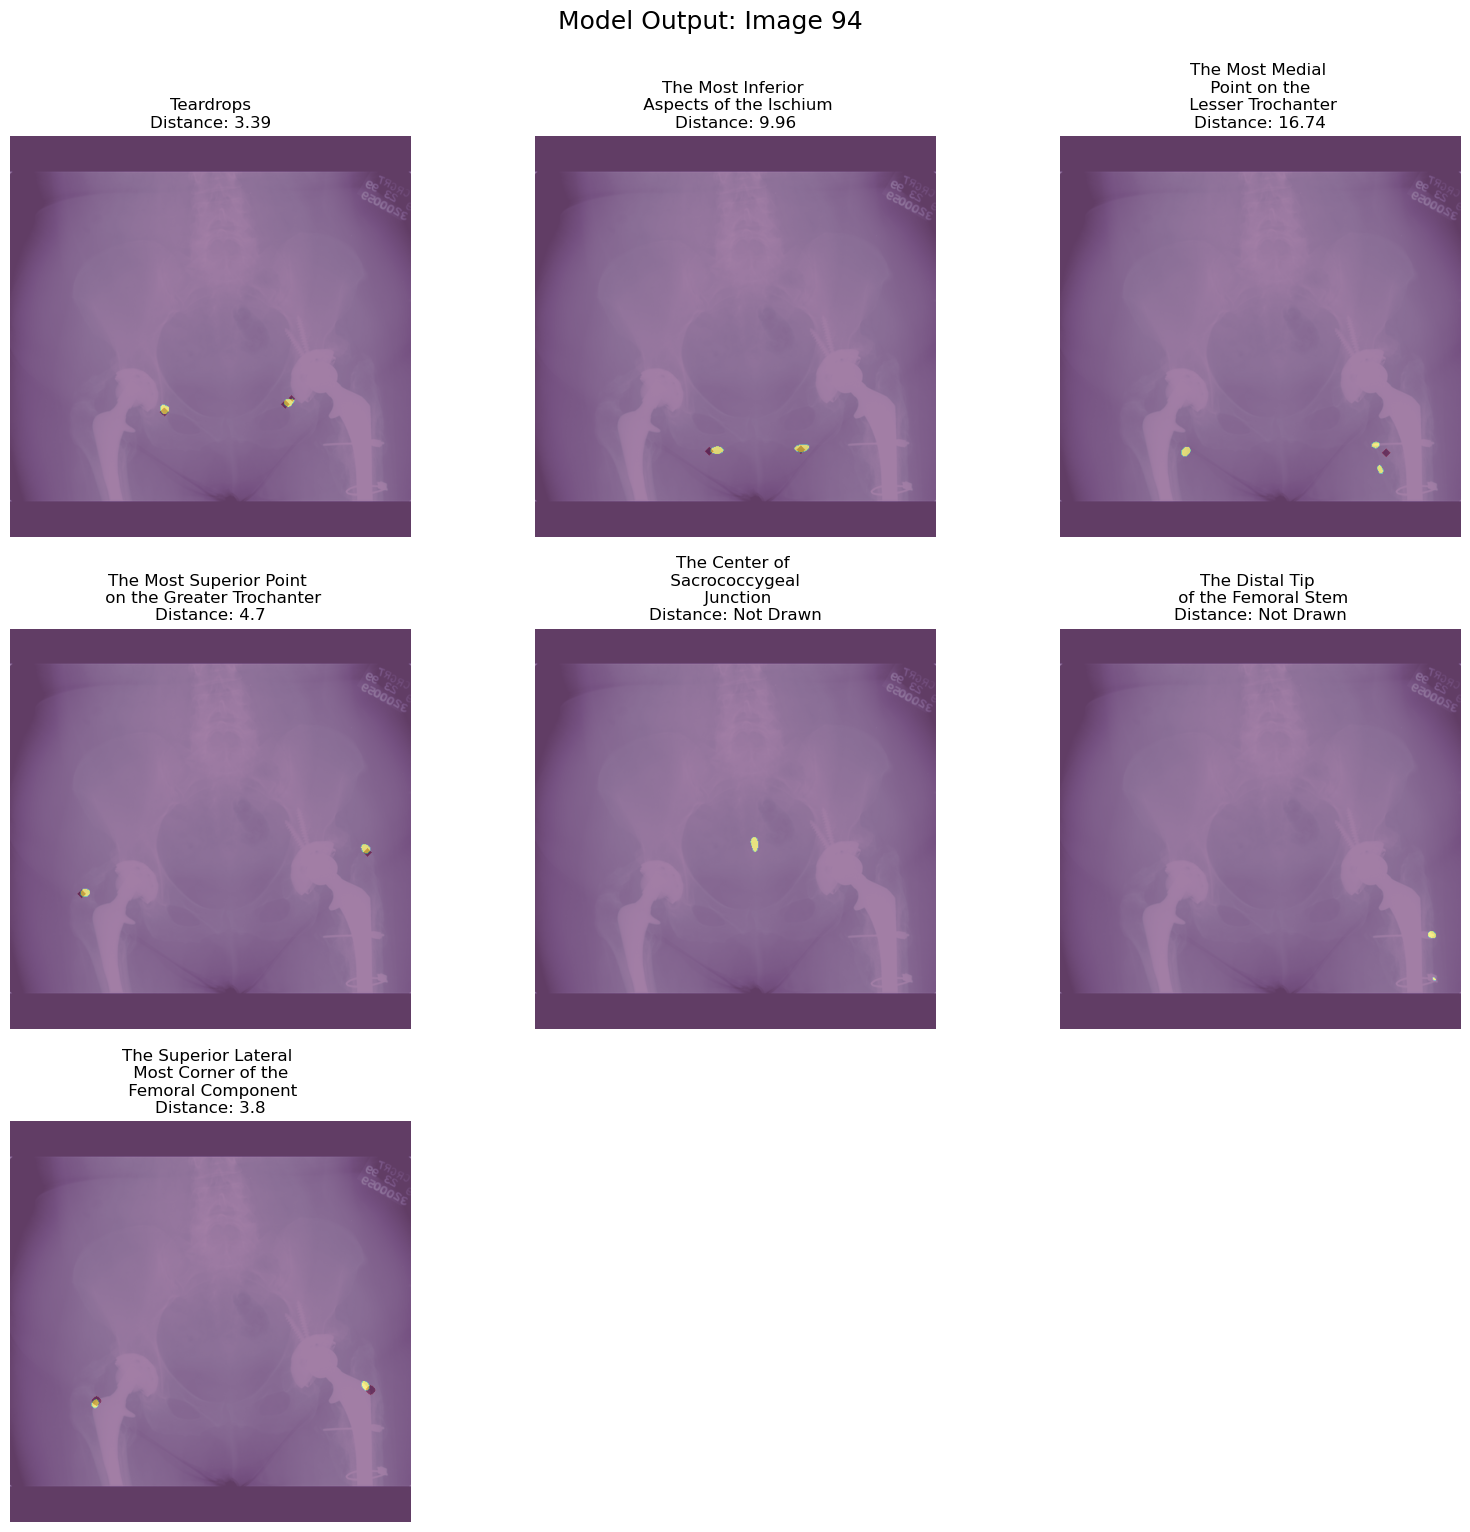

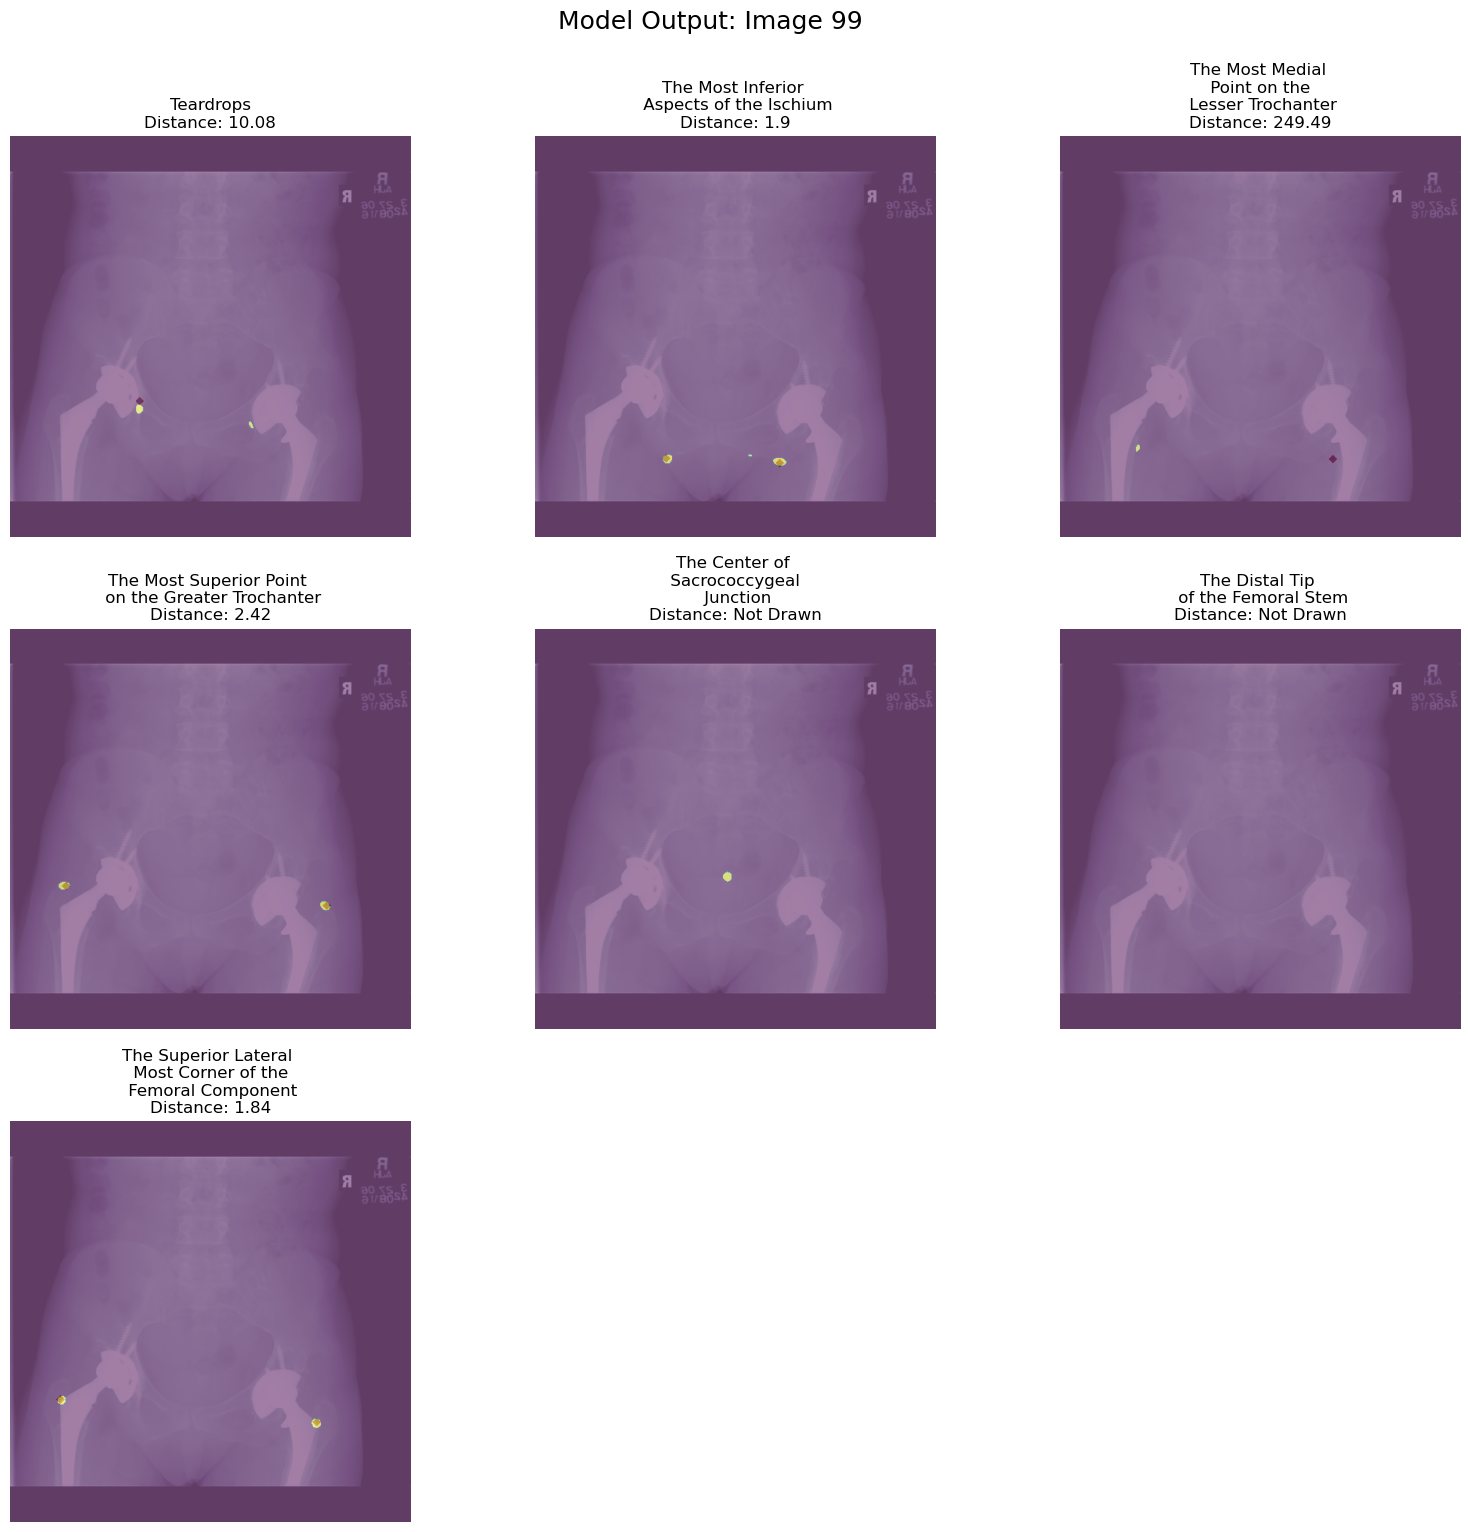

In [15]:
NUM_CLASSES = 7
NCOLS = 3
NROWS = NUM_CLASSES // NCOLS + (NUM_CLASSES % NCOLS > 0)

IMG_NUM = 0
fig_list = []
for test_image, test_labels in test_loader_1:
    IMG_NUM += 1
    with torch.no_grad():
        if IMG_NUM in df_above_thresh["img_num"].tolist():
            test_labels, test_outputs = inference(model, test_image, test_labels)

            ## Figure Time
            plt.figure( figsize=(20,18))
            plt.subplots_adjust(
                hspace=0.23,
                wspace=.05,
            )
            plt.suptitle(f"Model Output: Image {str(IMG_NUM)}", fontsize=18, y=0.95)
            i=0
            for n, anat_label in enumerate(anatomical_labels_dict):
                if anat_label["type"] == "point":
                    try:
                        DISTANCE = round(df_above_thresh[
                            (df_above_thresh["img_num"] == IMG_NUM) &
                            (df_above_thresh["struct"] == anat_label["name"])
                        ]["min_distance"].values[0],2)
                    except IndexError as e:
                        try:
                            DISTANCE = round(df2_below_thresh[
                                (df2_below_thresh["img_num"] == IMG_NUM) &
                                (df2_below_thresh["struct"] == anat_label["name"])
                            ]["min_distance"].values[0],2)
                        except IndexError as e:
                            DISTANCE = "Not Drawn"

                    ax = plt.subplot(NROWS, NCOLS, i + 1)
                    mask = test_outputs[0].cpu()[n]
                    gt_mask = test_labels[0].cpu()[n]
                    ax.imshow(
                        ndimage.rotate(test_image[0].cpu()[0],90),
                        alpha=1.0,
                        cmap=plt.cm.bone
                    )
                    ax.imshow(ndimage.rotate(gt_mask, 90), alpha=0.5, cmap=plt.cm.Reds)
                    ax.imshow(ndimage.rotate(mask, 90), alpha=0.5)
                    ax.axis('off')
                    ax.set_title(
                        f"{anat_label['name_formatted']}\n"
                        f"Distance: {DISTANCE}"
                    )
                    i+=1